In [2]:
import numpy as np
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import DigitalAnalogDevice
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import time

# Helper functions

### Plot the distribution of the results

In [3]:
# helper function
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5)
    plt.xticks(rotation="vertical")
    plt.show()

### Function to generate the pascal triangle coordinates

In [4]:
def generate_pascal_triangle_coords(num_atoms, min_distance=4.0):
    """
    Generate coordinates in a Pascal Triangle layout.

    Args:
        num_atoms (int): Total number of atoms. 
                         Values 1, 3, 6, 10, or 11/12 supported (extra atoms added reasonably).
        min_distance (float): Minimum spacing between atoms.

    Returns:
        coords (np.ndarray): Array of shape (n, 2) with 2D coordinates.
    """
    triangle_numbers = {1, 3, 6, 10}
    coords = []
    h = min_distance * np.sqrt(3) / 2  # Vertical spacing for equilateral triangle

    # Handle exact triangle numbers
    if num_atoms in triangle_numbers:
        n = int((np.sqrt(8 * num_atoms + 1) - 1) / 2)
        for row in range(n):
            num_in_row = row + 1
            x_offset = - (num_in_row - 1) * min_distance / 2
            y = -row * h
            for i in range(num_in_row):
                x = x_offset + i * min_distance
                coords.append((x, y))

    elif num_atoms == 11:
        # 10 from full triangle + 1 at center bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((0.0, -4 * h))  # Add one atom center bottom

    elif num_atoms == 12:
        # 10 from full triangle + 1 left-bottom + 1 right-bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((-min_distance, -4 * h))  # Left of bottom row
        coords.append((min_distance, -4 * h))   # Right of bottom row

    else:
        raise ValueError("Only supports 1, 3, 6, 10, 11, or 12 atoms for Pascal triangle layout.")

    return np.array(coords)

### Generate a QUBO matrix from a set of coordinates

In [67]:
def coordinates_to_Q(coords, C6=DigitalAnalogDevice.interaction_coeff, diag_val=-10.0):
    """
    Given a list of 2D coordinates, return a QUBO matrix Q.
    
    Args:
        coords: np.array of shape (n, 2)
        C6: interaction coefficient (default in Hz·μm⁶)
        diag_val: value to set for diagonal elements

    Returns:
        Q matrix (n x n)
    """
    coords = np.array(coords)
    distances = squareform(pdist(coords))  # Shape (n, n)
    with np.errstate(divide='ignore'):
        interaction = np.where(distances != 0, C6 / distances**6, 0.0)

    Q = interaction.copy()
    np.fill_diagonal(Q, diag_val)
    return Q

### QAOA optimisation helper functions

In [68]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

# Lets get the register position from the QUBO :

In [69]:
coords = generate_pascal_triangle_coords(12, min_distance=5.0)
Q = coordinates_to_Q(coords)

#### Find optimal bitstring from Q classically

In [70]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
classic_costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    classic_costs.append(cost)
zipped = zip(bitstrings, classic_costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('100000100100', -27.14493707061728), ('100000000110', -26.709843995863842), ('100000100001', -26.709843995863842)]


In [71]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)
costs = []
np.random.seed(0)
x0 = coords.flatten() # np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))


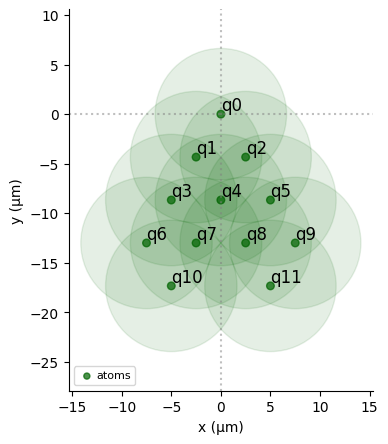

In [72]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

# Lets now do QAA and find the state that minimize our QUBO

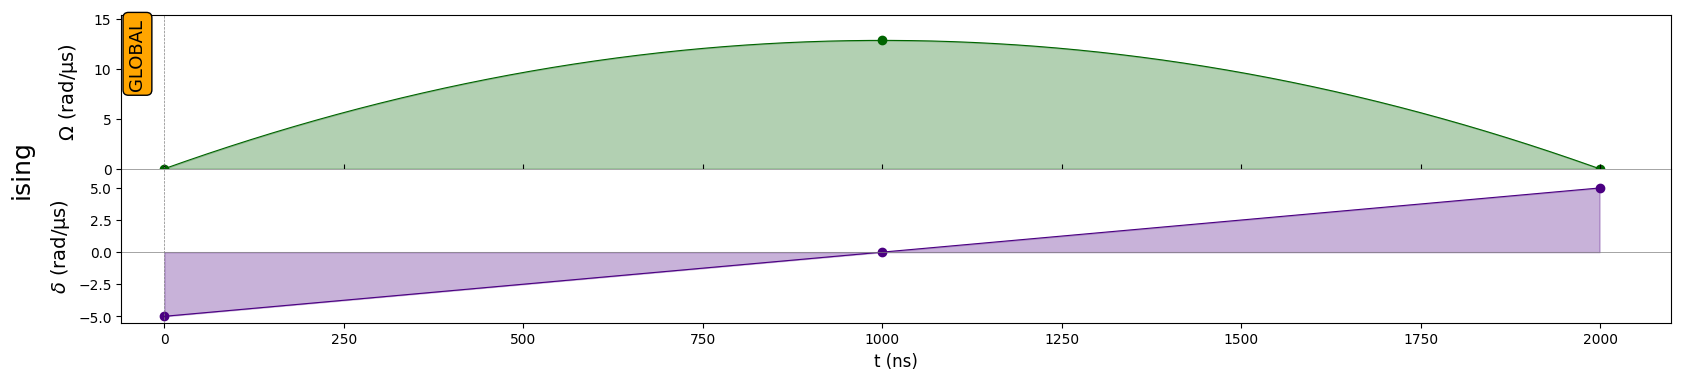

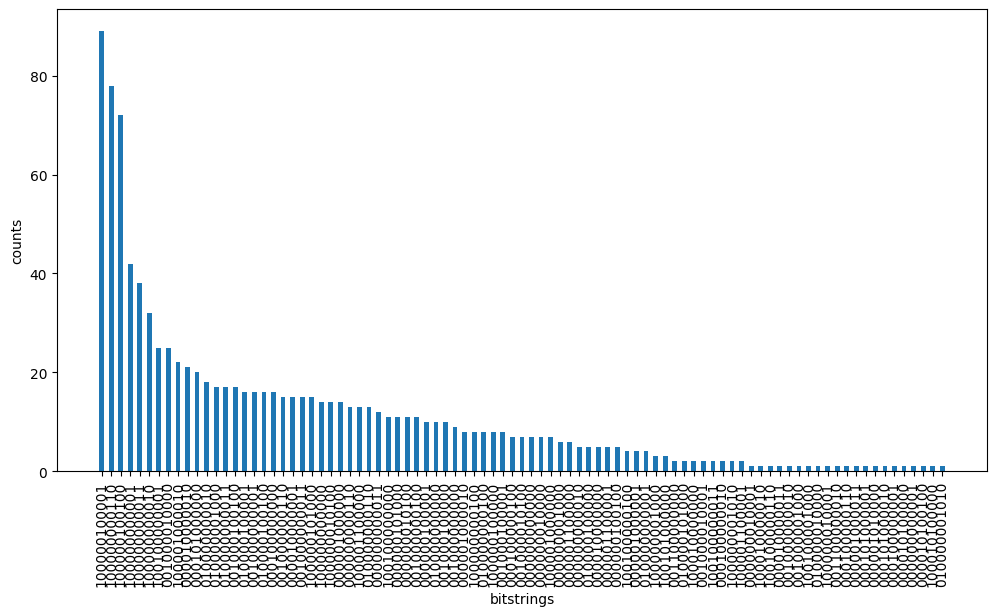

energy : -16.58050641432214


In [74]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 2000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
sequence_QAA = Sequence(reg, DigitalAnalogDevice)
sequence_QAA.declare_channel("ising", "rydberg_global")
sequence_QAA.add(adiabatic_pulse, "ising")
sequence_QAA.draw()
simul_QAA = QutipEmulator.from_sequence(sequence_QAA)
results_QAA = simul_QAA.run()
final_QAA = results_QAA.get_final_state()
count_dict_QAA = results_QAA.sample_final_state()
plot_distribution(count_dict_QAA)
print(f"energy : {get_cost(count_dict_QAA, Q)}")

# Saving sequence to json to be imported into pulser studio

In [75]:
s_readable = sequence_QAA.to_abstract_repr(
json_dumps_options={"indent": 1},
seq_name=f"qaa_seq_{time.time()}",
)
with open(f"QAA_{time.time()}.json", "w") as f:
    f.write(s_readable)

# Lets now use QAOA to find the state that minimize our QUBO

#### Unfortunately, the time it takes to optimise this, even with 1 repetition, takes too much time with 12 atoms.
we did get a result from this, but the optimizer did not converge; it only had 1 repetition

In [ ]:
LAYERS = 2
# The cost function to minimize
def func(param, *args):
    Q = args[0]
    sequence_QAOA = args[1]
    C = quantum_loop(param,sequence_QAOA)
    cost = get_cost(C, Q)
    return cost

# The function that runs the quantum loop
# This function is called by the optimizer to evaluate the cost function
def quantum_loop(parameters,sequence_QAOA,save=False):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = sequence_QAOA.build(t_list=t_params, s_list=s_params)
    if save:
        s_readable = assigned_seq.to_abstract_repr(
        json_dumps_options={"indent": 1},
        seq_name="qaoa_seq",
        )
        with open(f"QAOA_{time.time()}.json", "w") as f:
            f.write(s_readable)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

# Parametrized sequence
sequence_QAOA = Sequence(reg, DigitalAnalogDevice)
sequence_QAOA.declare_channel("ch0", "rydberg_global")

t_list = sequence_QAOA.declare_variable("t_list", size=LAYERS)
s_list = sequence_QAOA.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    sequence_QAOA.add(pulse_1, "ch0")
    sequence_QAOA.add(pulse_2, "ch0")

sequence_QAOA.measure("ground-rydberg")

scores_QAOA = []
params = []
for repetition in range(1):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=(Q, sequence_QAOA),
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 5},
        )
        scores_QAOA.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass
    print(f"Repetition {repetition} done.")

optimal_count_dict = quantum_loop(params[np.argmin(scores_QAOA)],sequence_QAOA)
plot_distribution(optimal_count_dict)

Repetition 0 done.


TypeError: quantum_loop() missing 1 required positional argument: 'sequence_QAOA'

In [47]:
scores_QAOA

[15636.954793541321]

In [50]:
params

[array([8.34771442, 2.4946938 , 8.45550597, 1.52766153])]

In [54]:
# save the sequence with the best parameters
index = np.argmin(scores_QAOA)
best_params = params[index]
quantum_loop(best_params, sequence_QAOA, save=True)

Counter({'111111111111': 1000})

In [ ]:
# QAA cost of optimized results : 
qaa_cost = get_cost(count_dict_QAA, Q)
print(f"Mninimal energy found using QAA method : {qaa_cost}")

# QAOA cost of optimized results :
qaoa_cost = func(best_params, Q, sequence_QAOA)
print(f"Mninimal energy found using QAOA method : {qaoa_cost}")

# Classical cost of Q :
print(f"Minimal energy found using classical methods : {sort_zipped[:1]}")

Cost using QAA method : -16.449517468128704
Cost using QAOA method : 15636.954793541321
[('100000100100', -27.14493707061728)]


# Study of chaotic system on pasqal technology 

In [ ]:
import numpy as np

def generate_grid_clustered_graph(grid_size=8, clustering=3, radius=1,
                                  total_atoms=12, min_distance=5.0, 
                                  minimal_capacity=0.2, max_radius=50.0):
    np.random.seed(0)
    positions = []

    # 1. Select cluster centers from center region (2 to 7)
    candidate_centers = [(i, j) for i in range(2, grid_size)
                                for j in range(2, grid_size)]
    cluster_center_indices = np.random.choice(len(candidate_centers), size=clustering, replace=False)
    cluster_centers = np.array([candidate_centers[i] for i in cluster_center_indices])

    # 2. Collect all valid cells around cluster centers
    possible_cells = set()
    for center in cluster_centers:
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                x, y = center[0] + dx, center[1] + dy
                if 1 <= x <= grid_size and 1 <= y <= grid_size:
                    possible_cells.add((x, y))
    possible_cells = list(possible_cells)
    center_offset = (grid_size + 1) / 2.0           # 4.5 for an 8×8 grid
    max_grid_radius = np.linalg.norm([center_offset - 1, center_offset - 1])
    scale = max_radius / max_grid_radius            # ≈ 10.1 µm per grid cell
    grid_min_dist = min_distance / scale            # 5 µm  →  0.49 cells
    def is_far_enough(candidate, others):
        return all(np.linalg.norm(candidate - p) >= grid_min_dist for p in others)

    # 3. Select atom positions
    selected_cells = []
    if len(possible_cells) >= total_atoms:
        np.random.shuffle(possible_cells)
        for cell in possible_cells:
            if is_far_enough(np.array(cell), selected_cells):
                selected_cells.append(np.array(cell))
            if len(selected_cells) == total_atoms:
                break
    else:
        selected_cells = [np.array(cell) for cell in possible_cells]
        while len(selected_cells) < total_atoms:
            rand = np.random.randint(1, grid_size + 1, size=2)
            if is_far_enough(rand, selected_cells):
                selected_cells.append(rand)

    positions = np.array(selected_cells, dtype=float)

    # 3.5 Scale to fit within max_radius from center (Pulser compatible)
    center_offset = (grid_size + 1) / 2.0
    positions -= center_offset  # center around (0, 0)

    max_grid_radius = np.linalg.norm([center_offset - 1, center_offset - 1])
    scale = max_radius / max_grid_radius
    positions *= scale

    # 4. Compute weights and normalized opacities
    distances = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=-1)
    with np.errstate(divide='ignore'):
        weights = np.where(distances > 0, 1 / distances**6, 0)
    max_weight = np.max(weights)
    opacities = np.maximum(weights / max_weight, minimal_capacity)

    return positions, cluster_centers, weights

In [79]:
def find_minimum_cost_classic(Q):
    bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
    classic_costs = []
    # this takes exponential time with the dimension of the QUBO
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q @ z
        classic_costs.append(cost)
    zipped = zip(bitstrings, classic_costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    return sort_zipped[0]

def find_minimum_cost_QAA(Q):
    # We choose a median value between the min and the max
    Omega = np.median(Q[Q > 0].flatten())
    delta_0 = -5  # just has to be negative
    delta_f = -delta_0  # just has to be positive
    T = 2000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    sequence_QAA = Sequence(reg, DigitalAnalogDevice)
    sequence_QAA.declare_channel("ising", "rydberg_global")
    sequence_QAA.add(adiabatic_pulse, "ising")
    #sequence_QAA.draw()
    simul_QAA = QutipEmulator.from_sequence(sequence_QAA)
    results_QAA = simul_QAA.run()
    final_QAA = results_QAA.get_final_state()
    count_dict_QAA = results_QAA.sample_final_state()
    return get_cost(count_dict_QAA, Q)

#### Generate_grid_clustered_graph generate cluster coordinates that we then transform into neutral atom in pasqal quantum computer
we use this to study the chaotic properties of pasqal's system

In [52]:
positions, cluster_centers, weight = generate_grid_clustered_graph(grid_size=8, clustering=1, radius=3,total_atoms=12, min_distance=5.0, minimal_capacity=0.2)
positions

array([[  5.05076272, -25.25381361],
       [  5.05076272,  15.15228817],
       [ 35.35533906,   5.05076272],
       [ 15.15228817, -15.15228817],
       [ 15.15228817,  -5.05076272],
       [ -5.05076272,  -5.05076272],
       [ 35.35533906,  -5.05076272],
       [ 15.15228817,  15.15228817],
       [ 35.35533906, -35.35533906],
       [ 25.25381361,   5.05076272],
       [ 25.25381361, -35.35533906],
       [ 25.25381361,  -5.05076272]])

clustering=1 radius=3



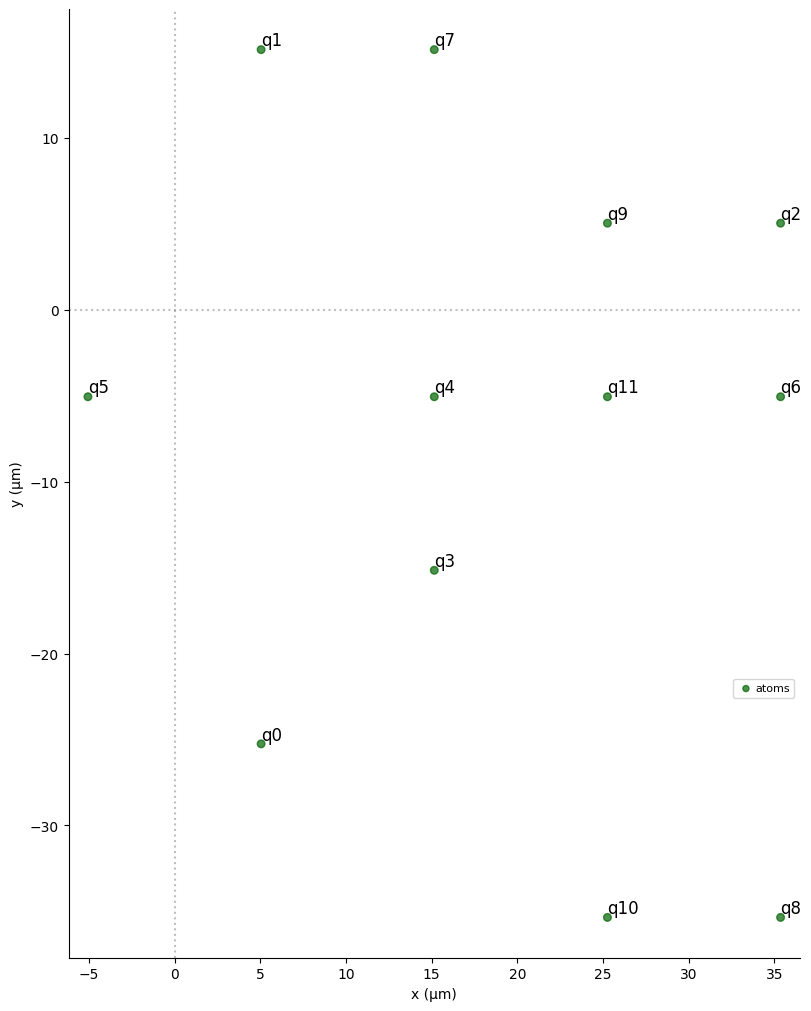

QAA lowest cost 4019.867449031787, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 149.08903179897388
clustering=1 radius=4



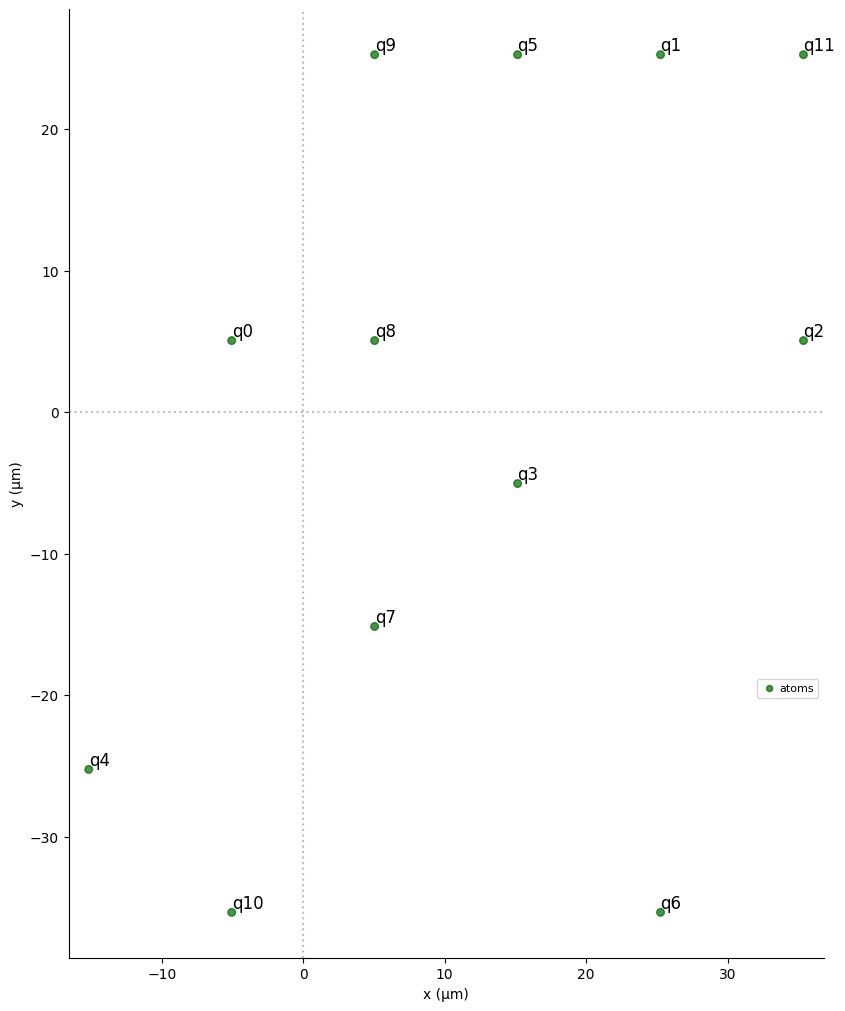

QAA lowest cost 4699.273009147394, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 174.1178450302641
clustering=1 radius=5



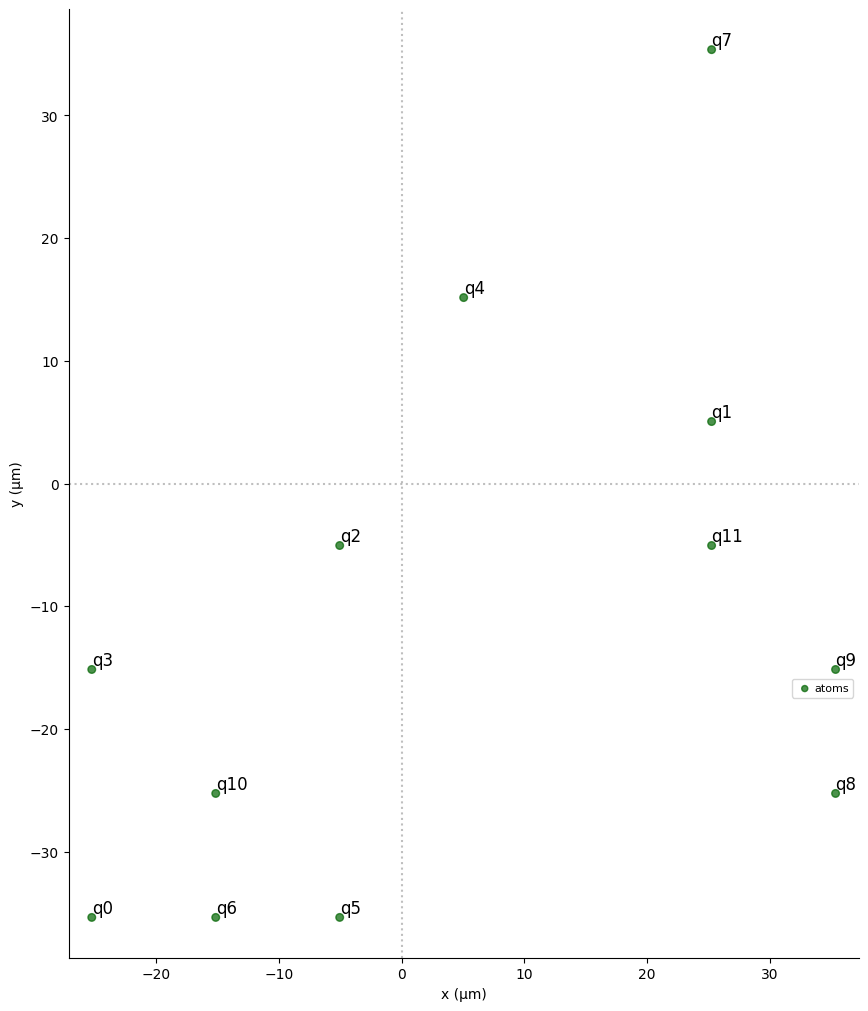

QAA lowest cost 5032.002131695874, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 186.37534710819813
clustering=1 radius=6



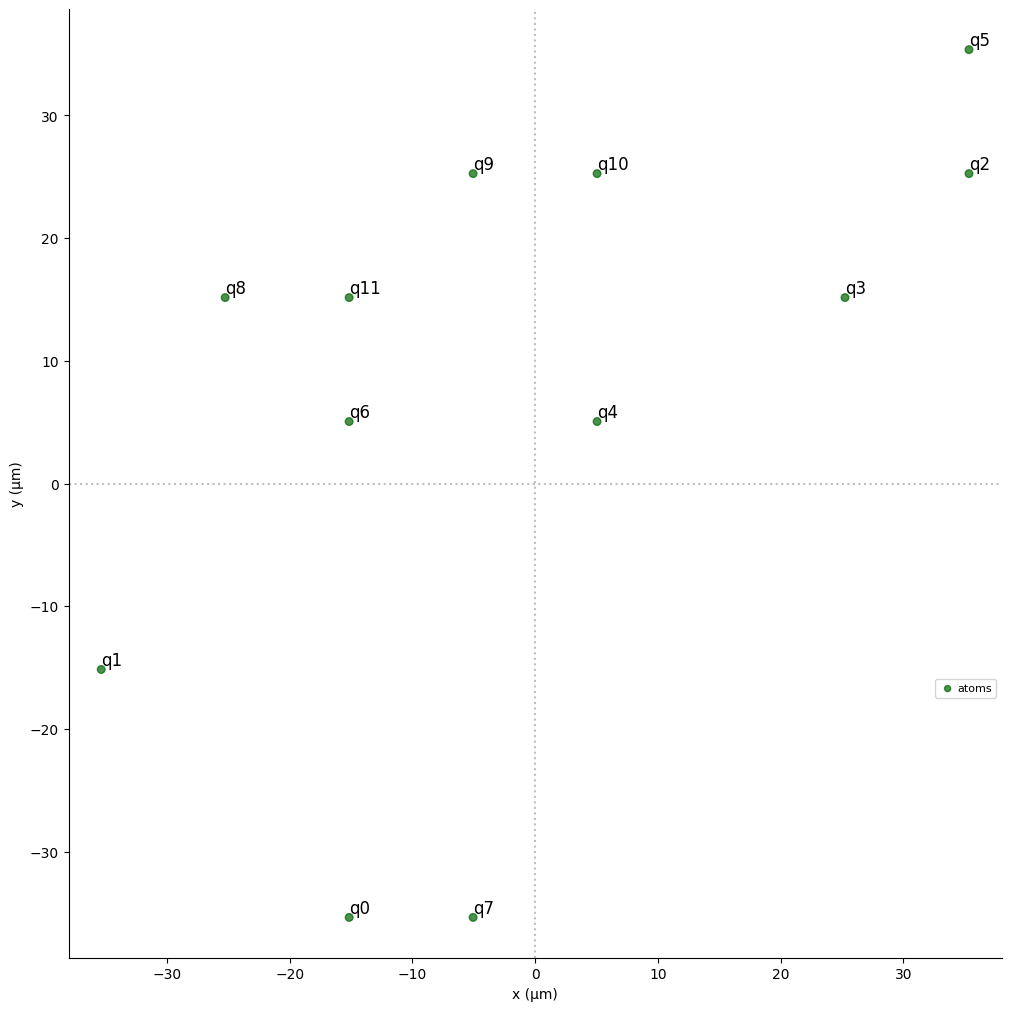

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=1 radius=7



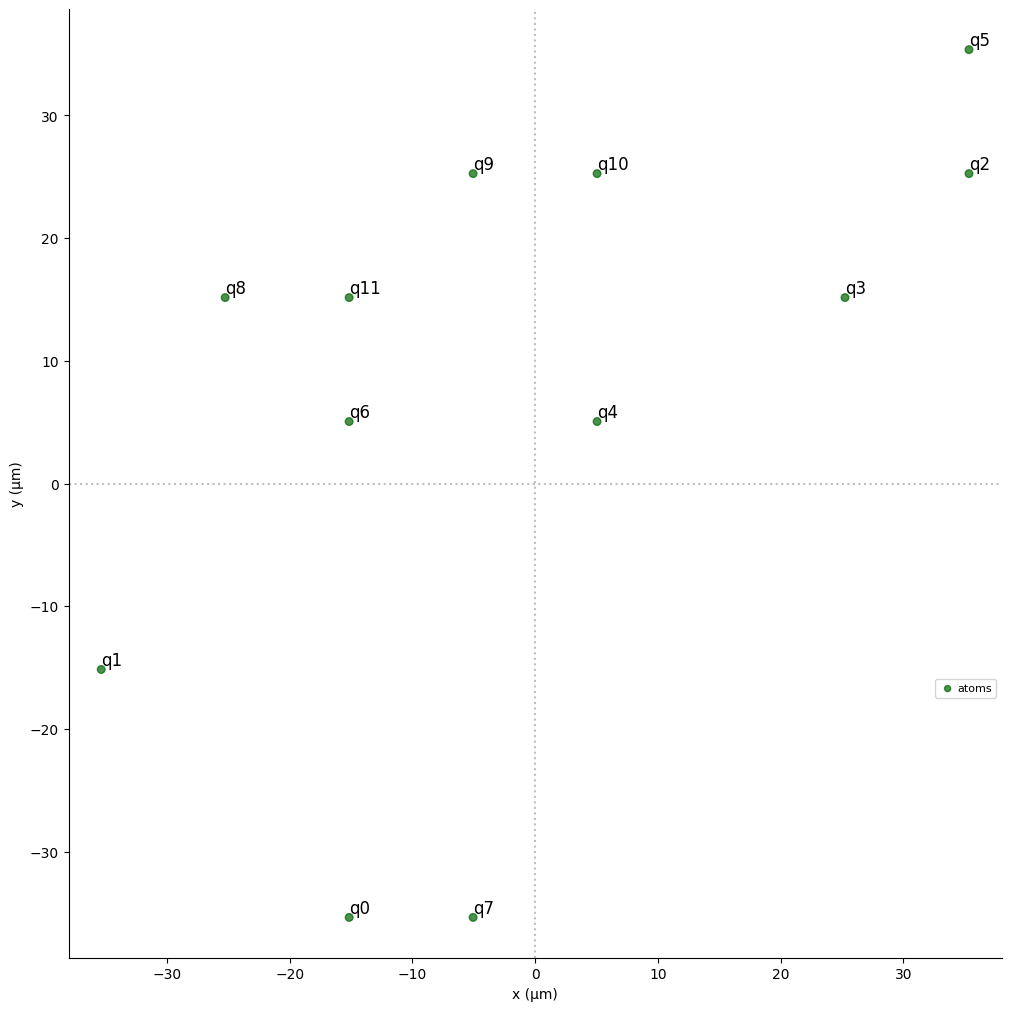

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=1 radius=8



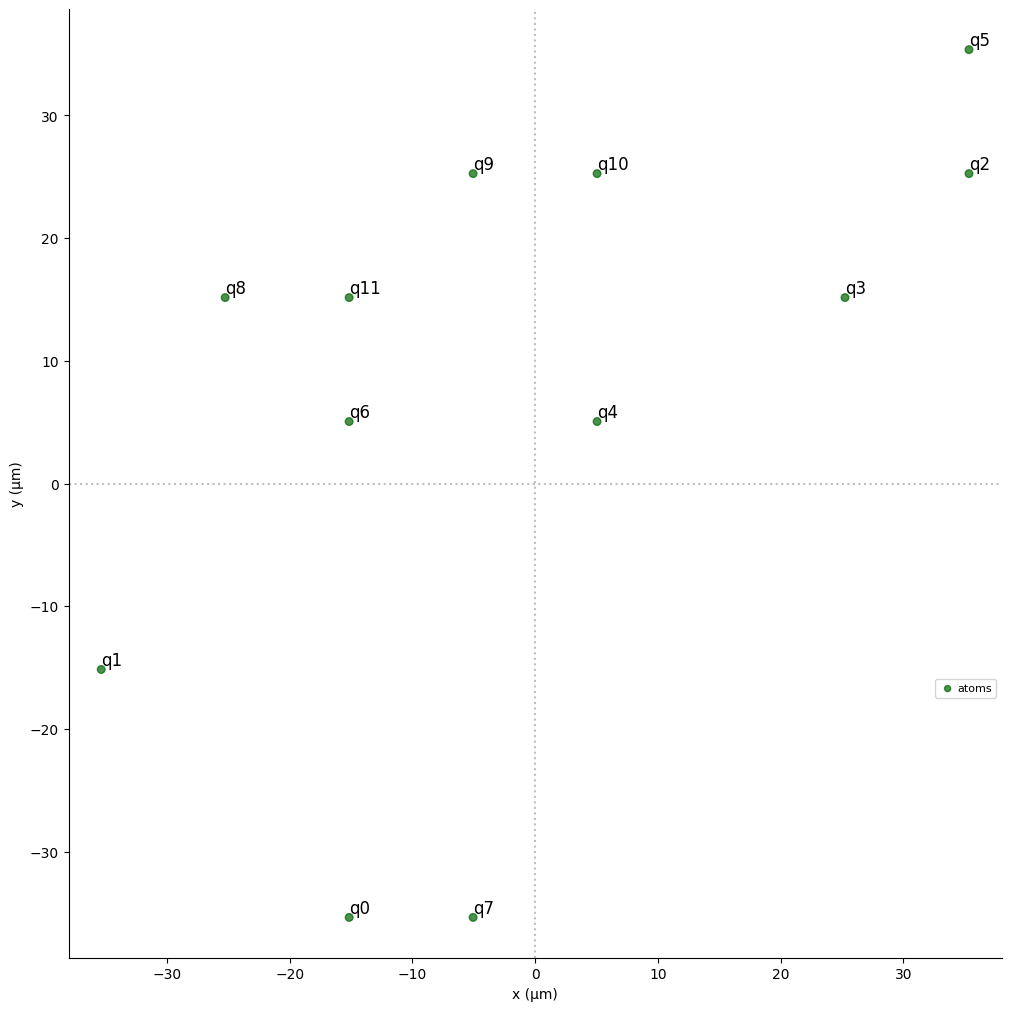

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=1 radius=9



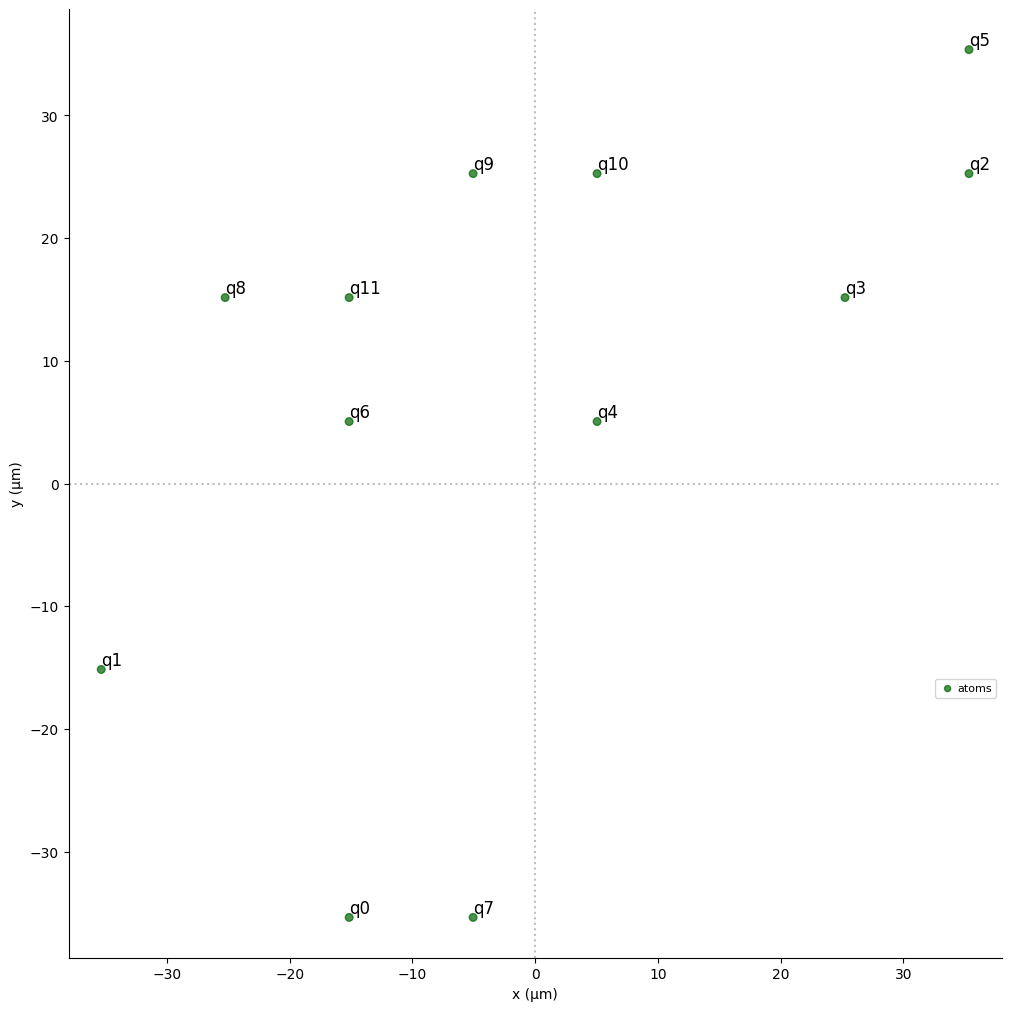

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=1 radius=10



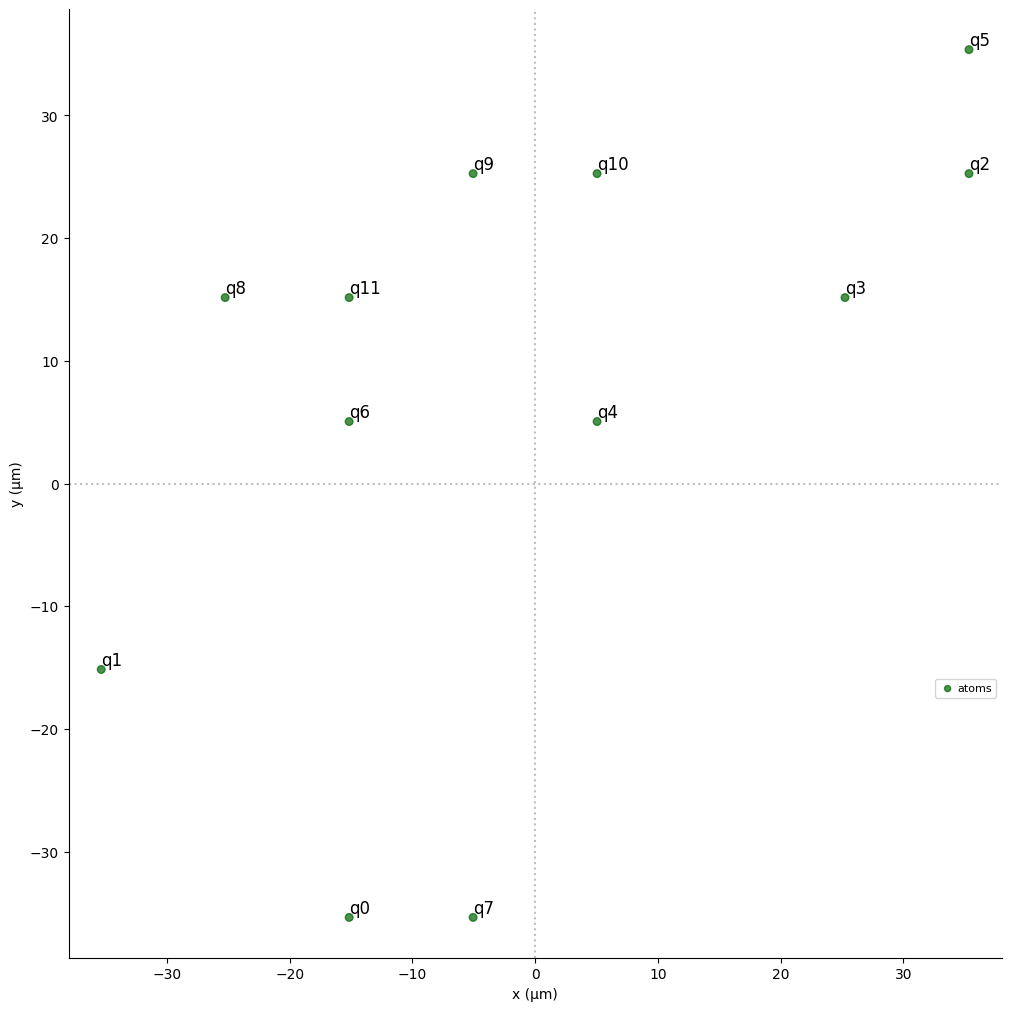

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=1 radius=11



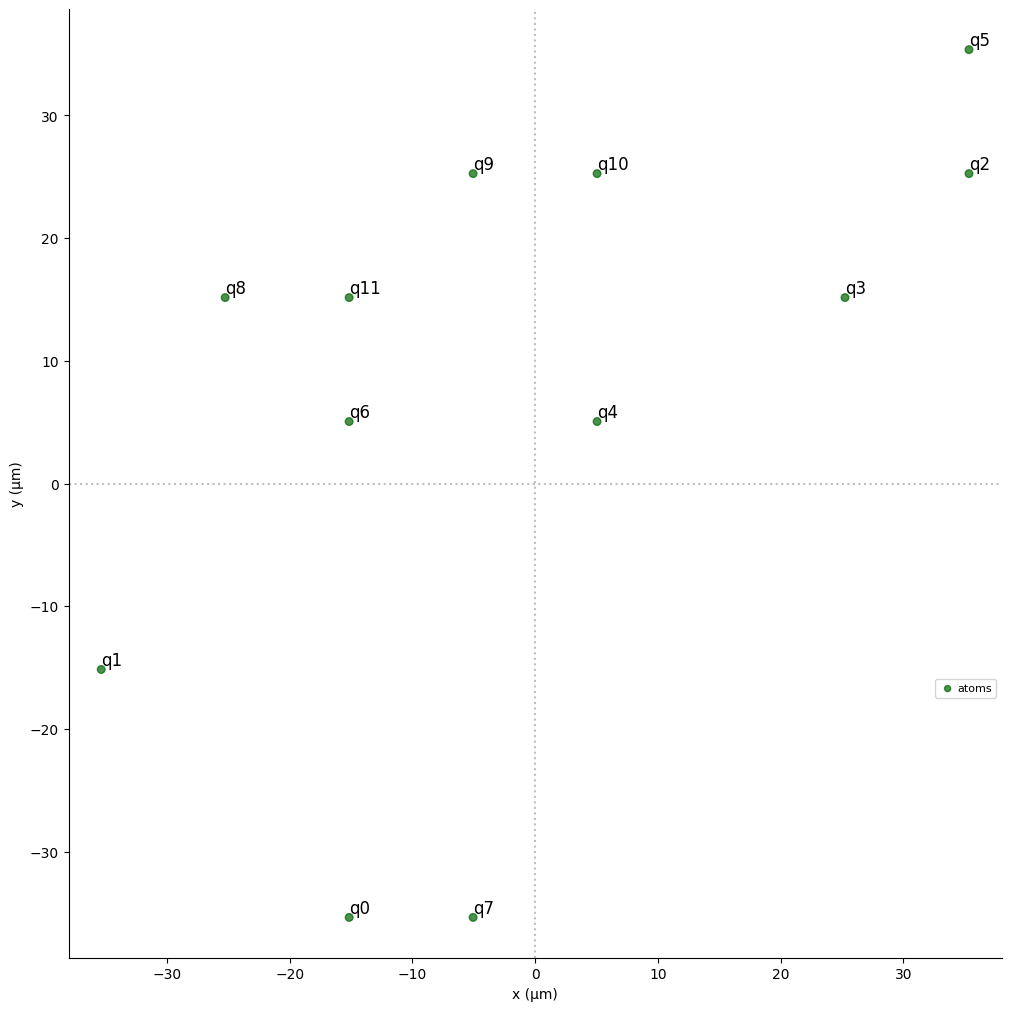

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=3



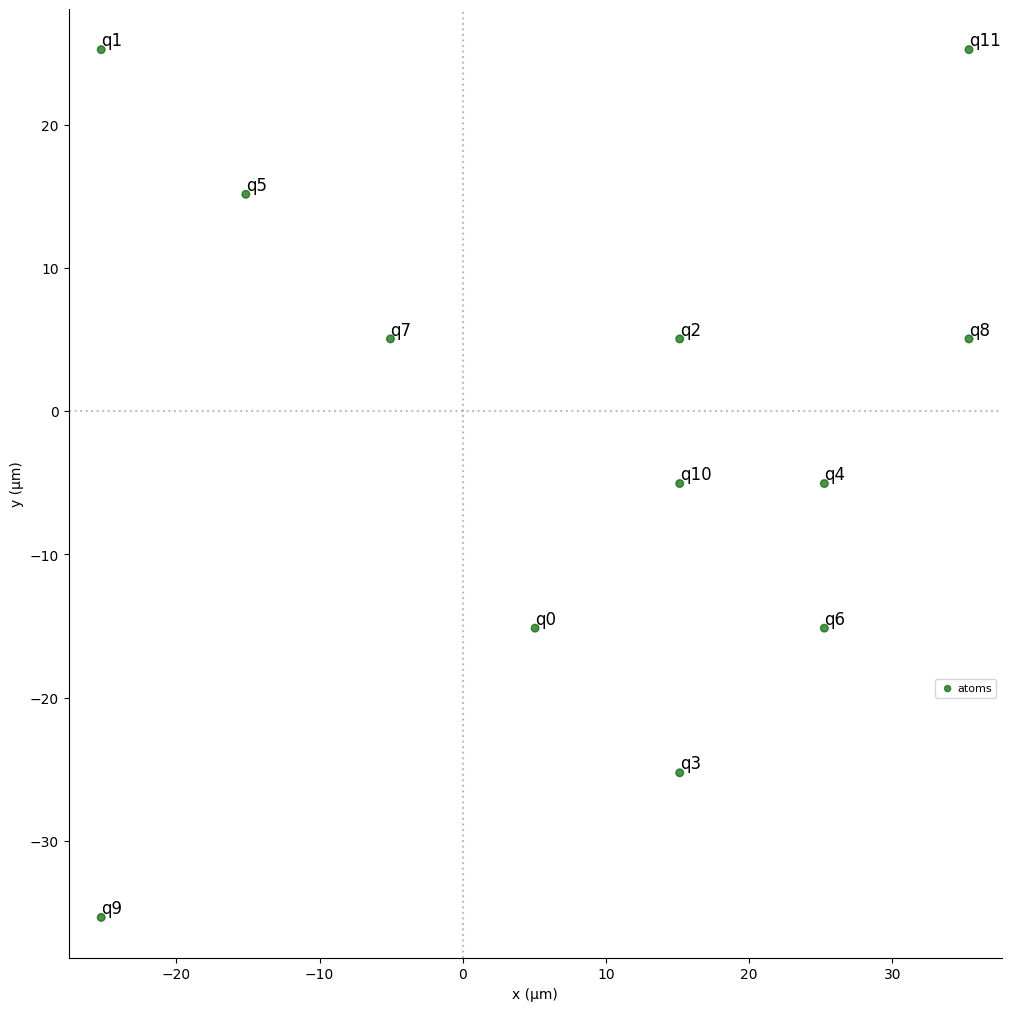

QAA lowest cost 5263.816114796747, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 194.91520787478643
clustering=2 radius=4



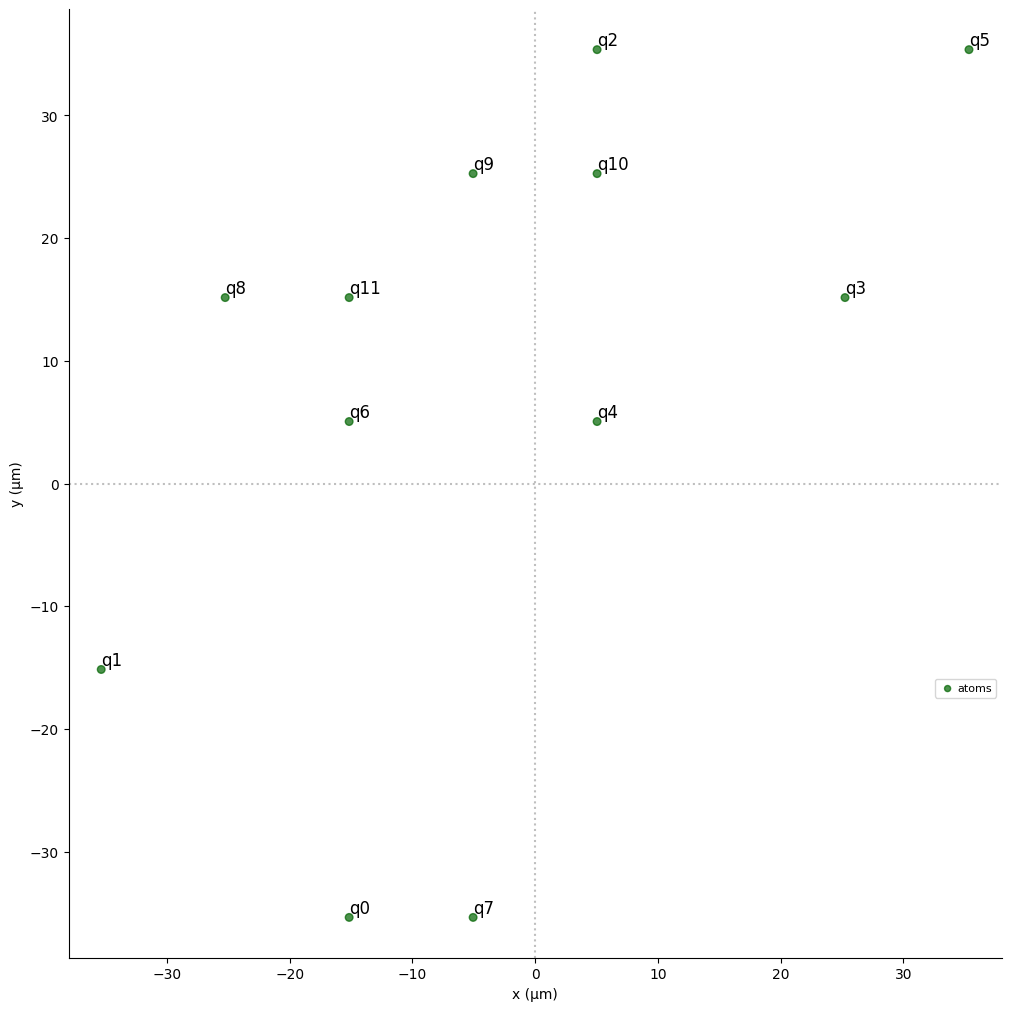

QAA lowest cost 5788.450129032971, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 214.24234843405145
clustering=2 radius=5



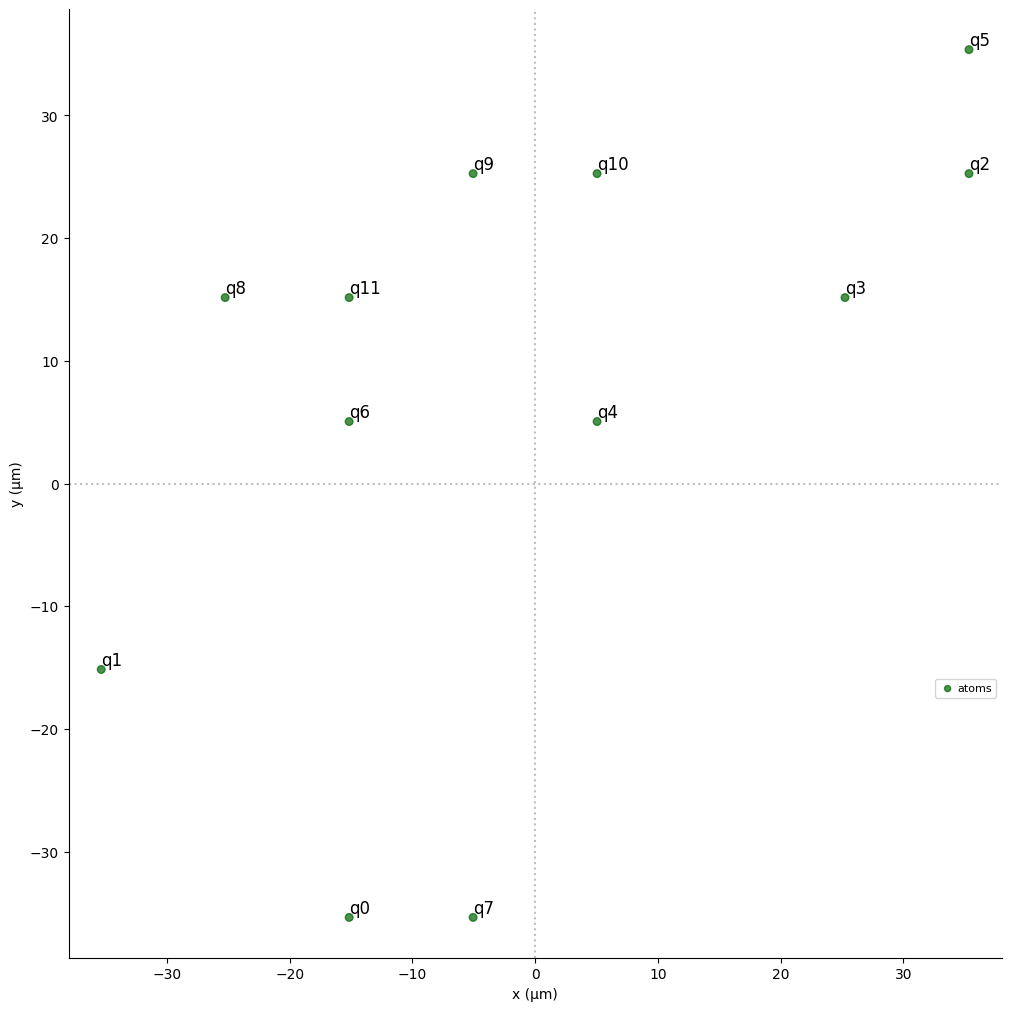

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=6



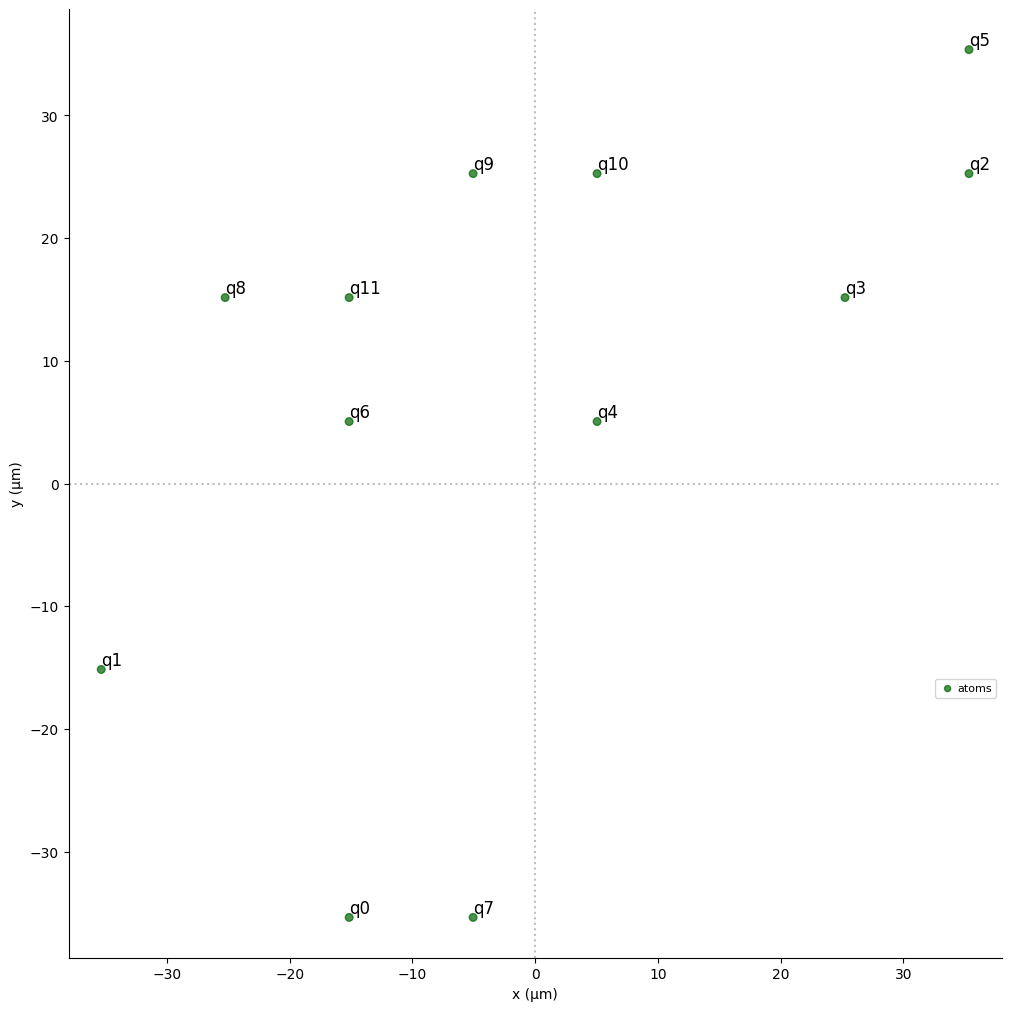

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=7



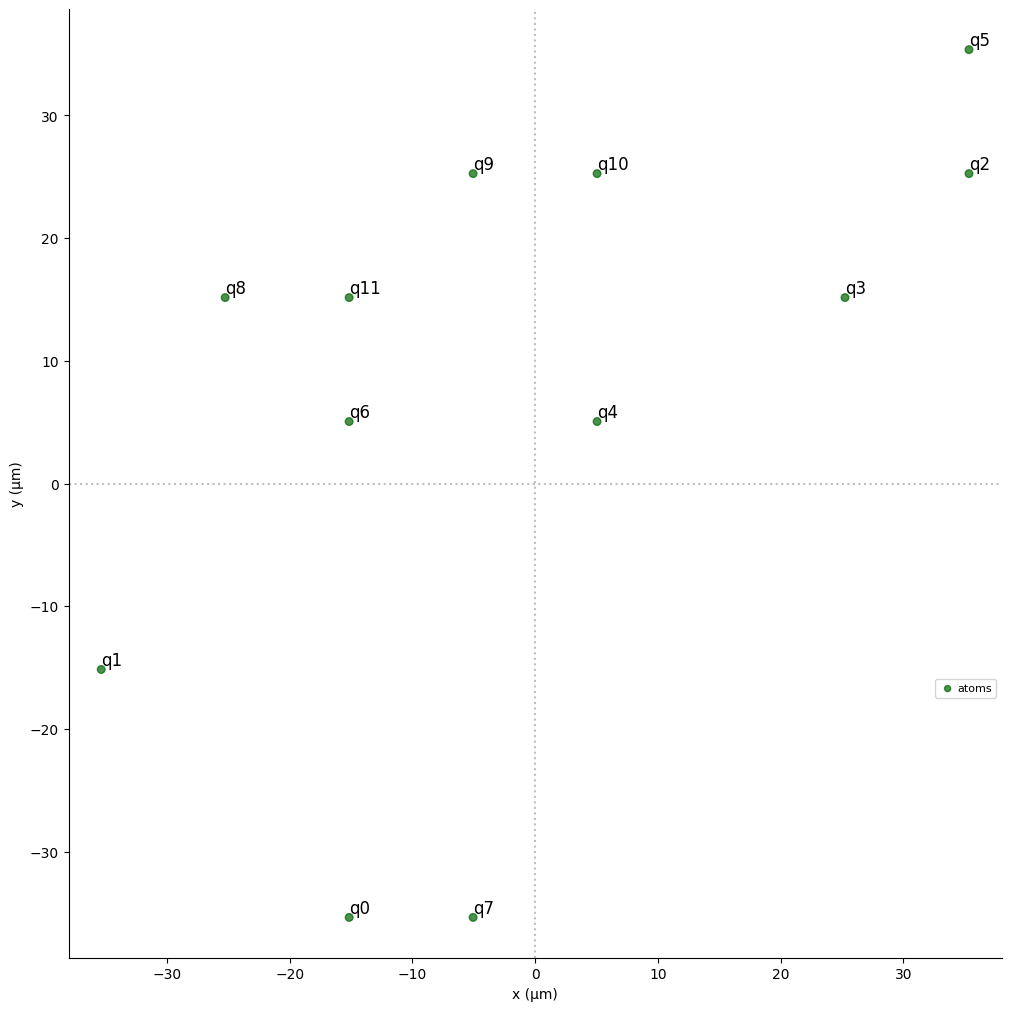

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=8



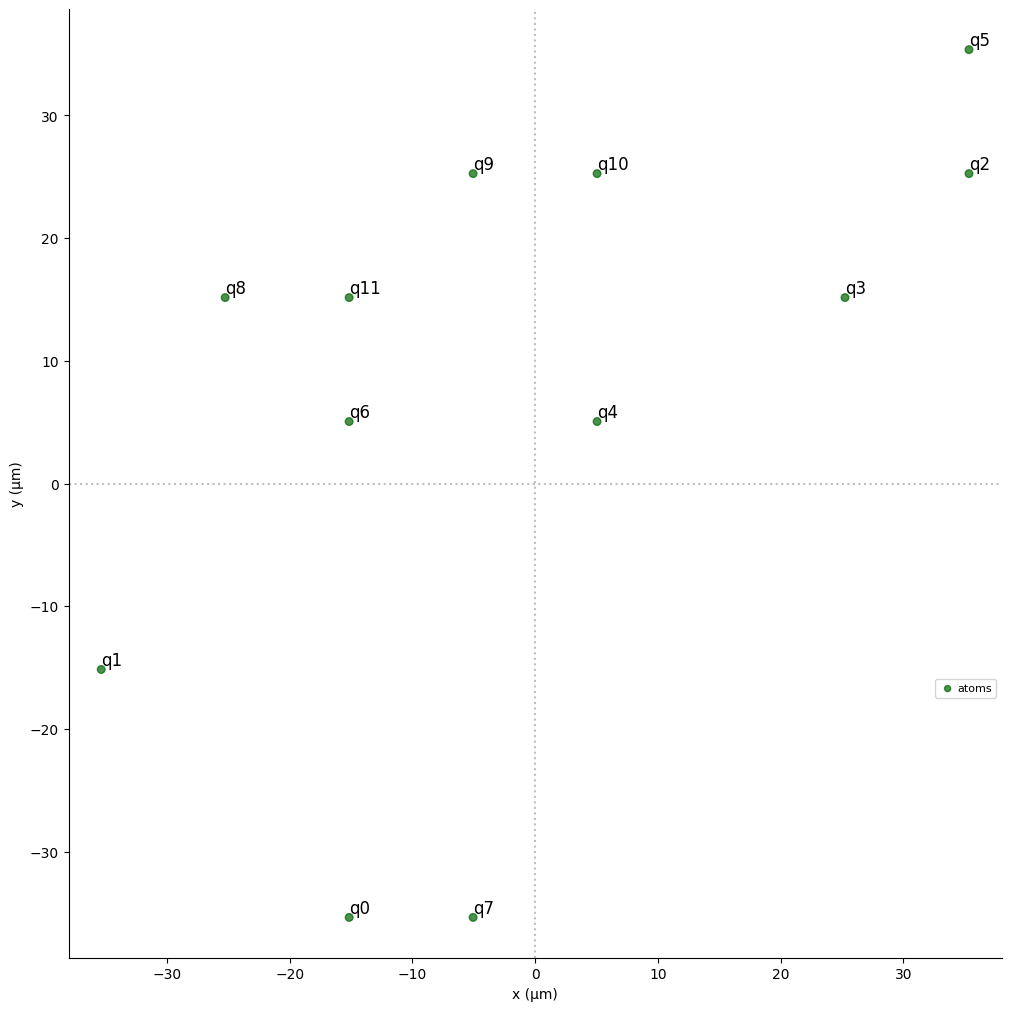

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=9



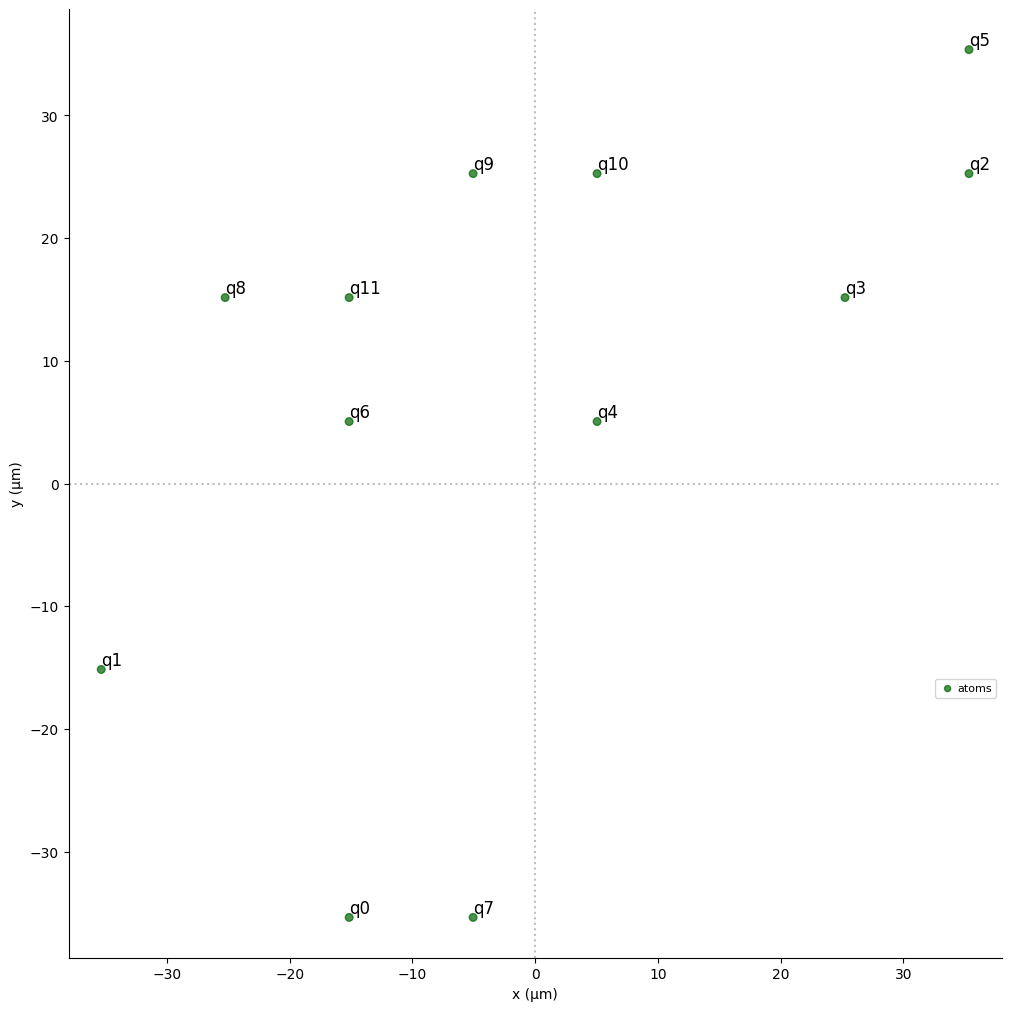

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=10



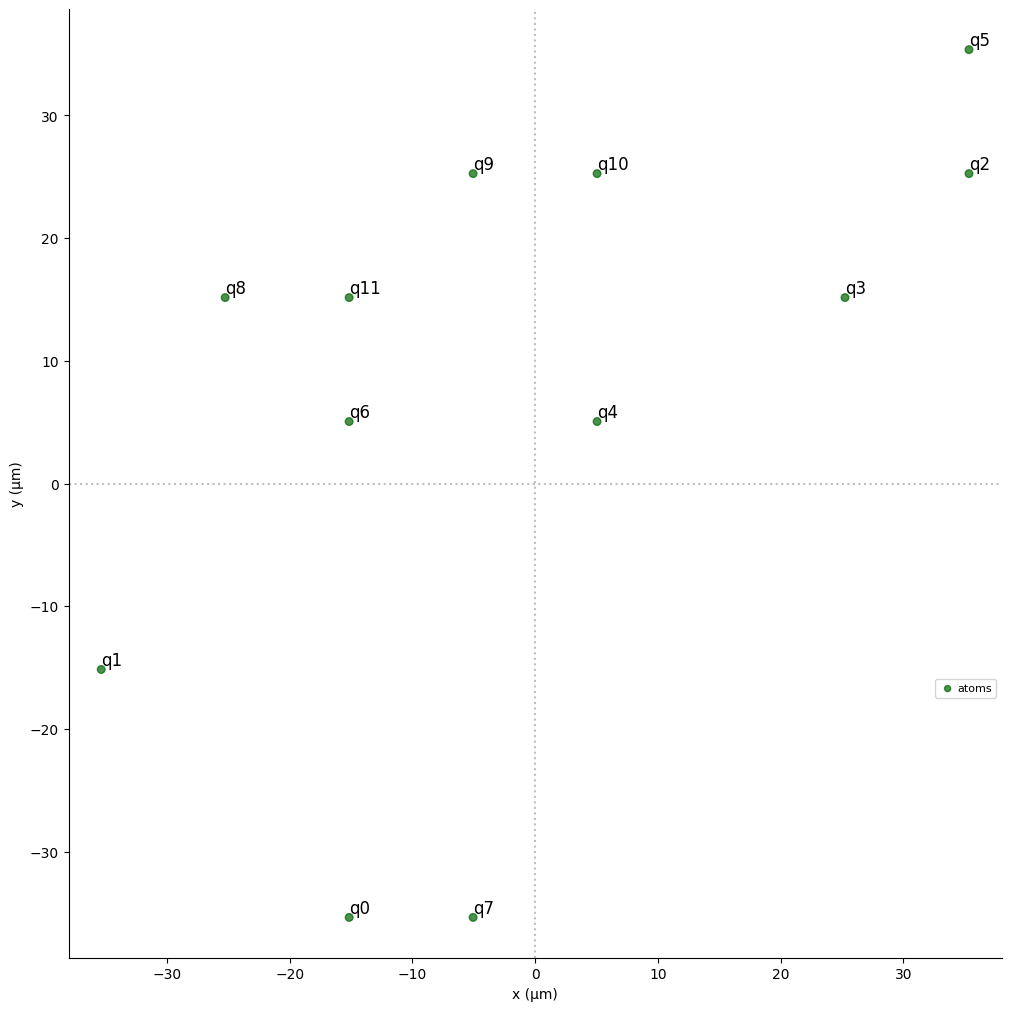

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=2 radius=11



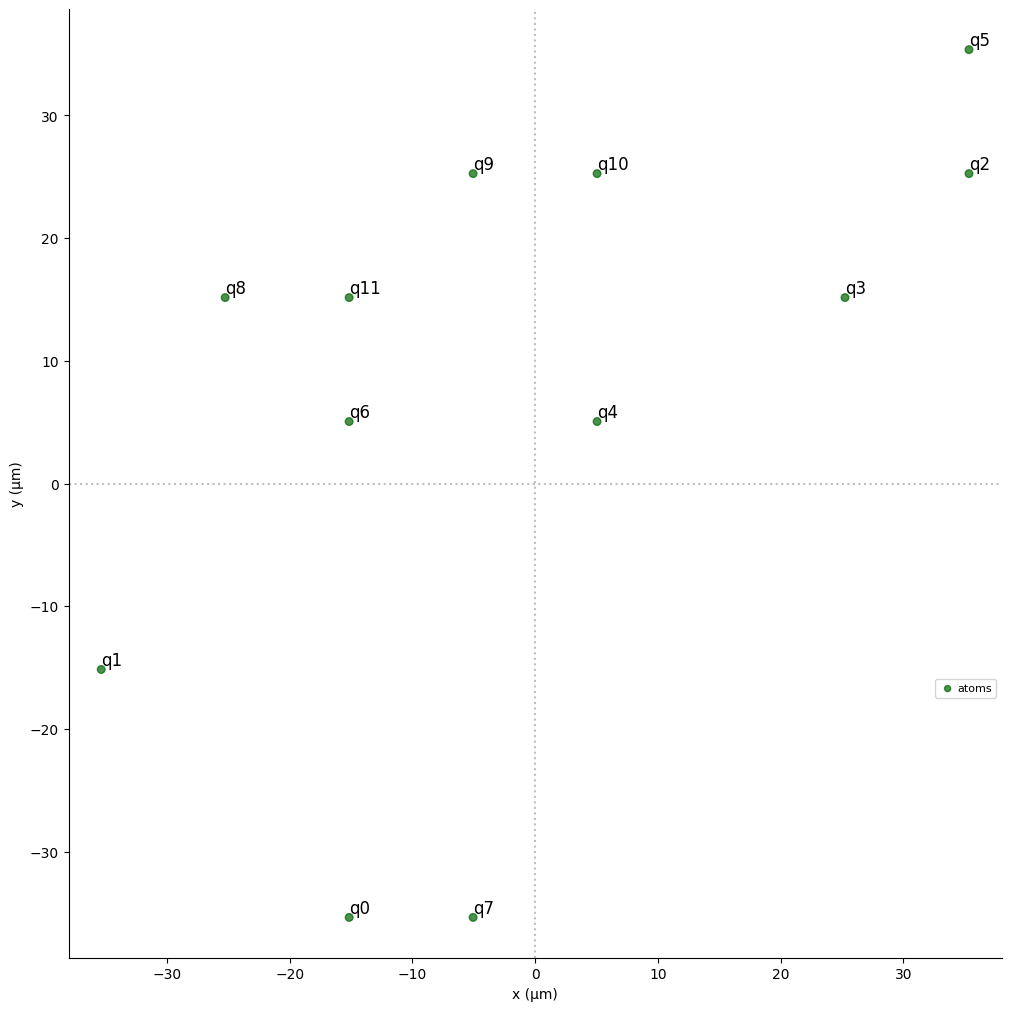

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=3



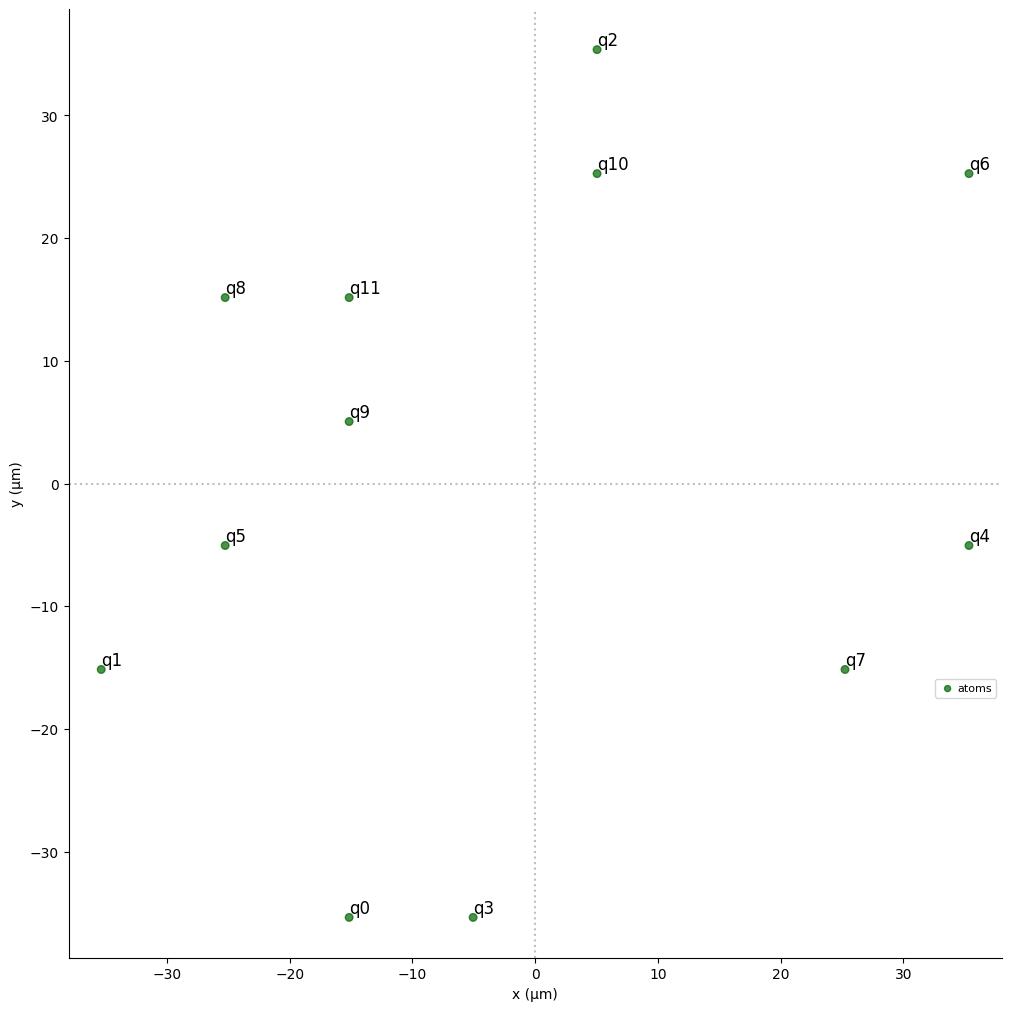

QAA lowest cost 4859.451290504174, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 180.01869795691033
clustering=3 radius=4



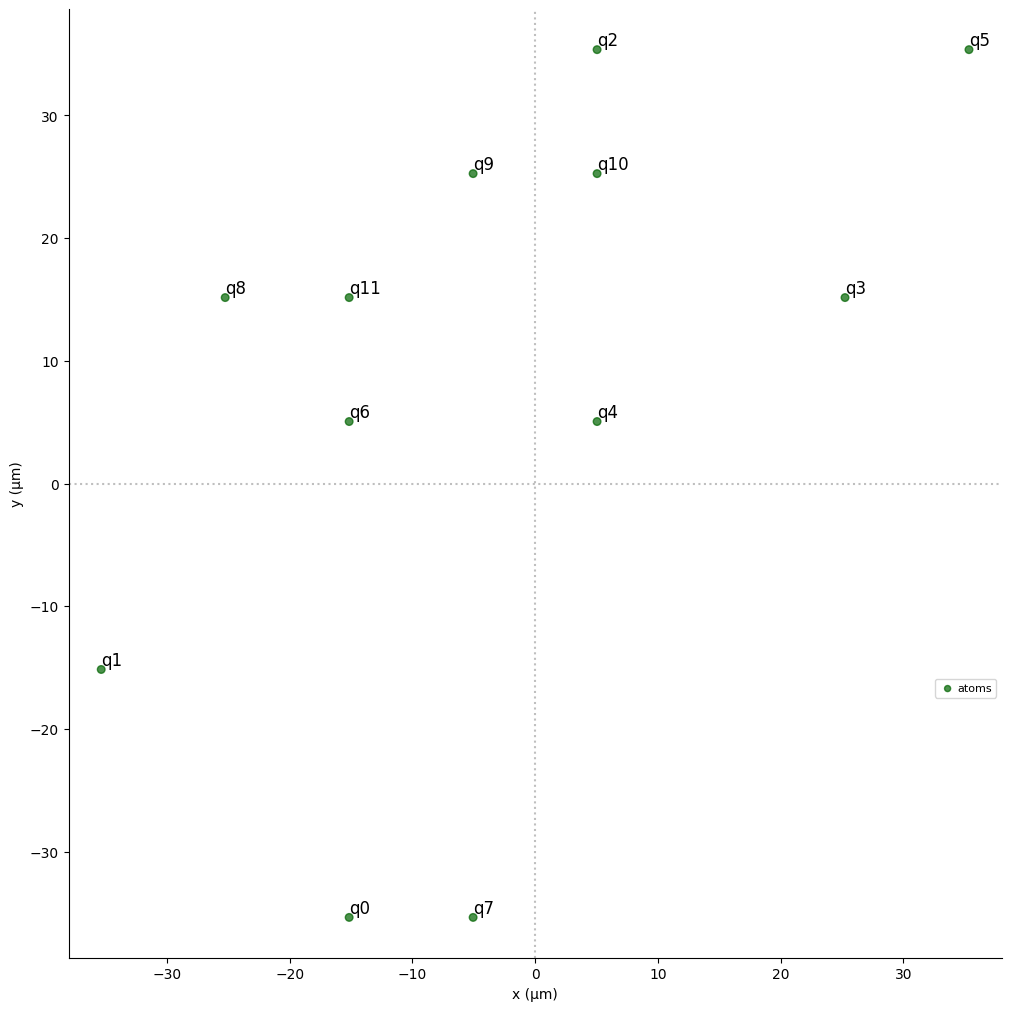

QAA lowest cost 5788.450129032971, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 214.24234843405145
clustering=3 radius=5



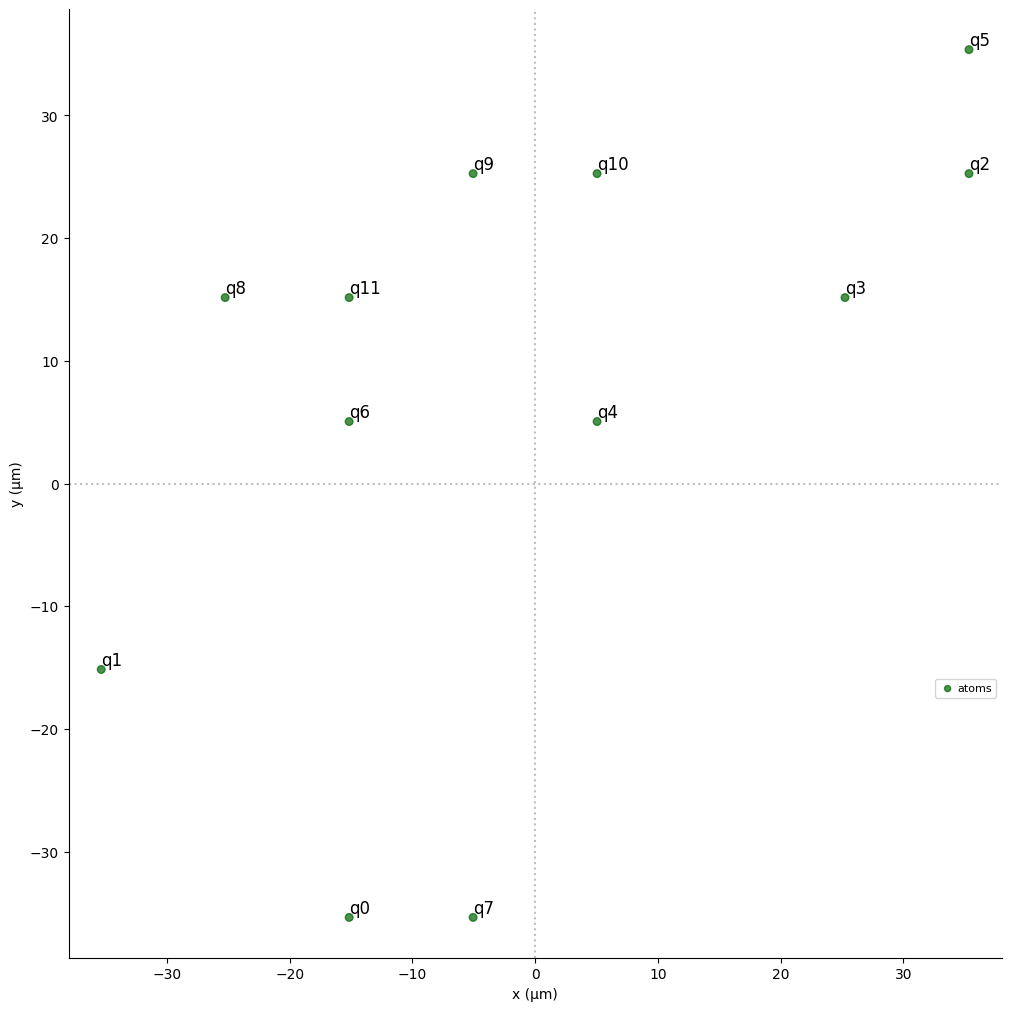

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=6



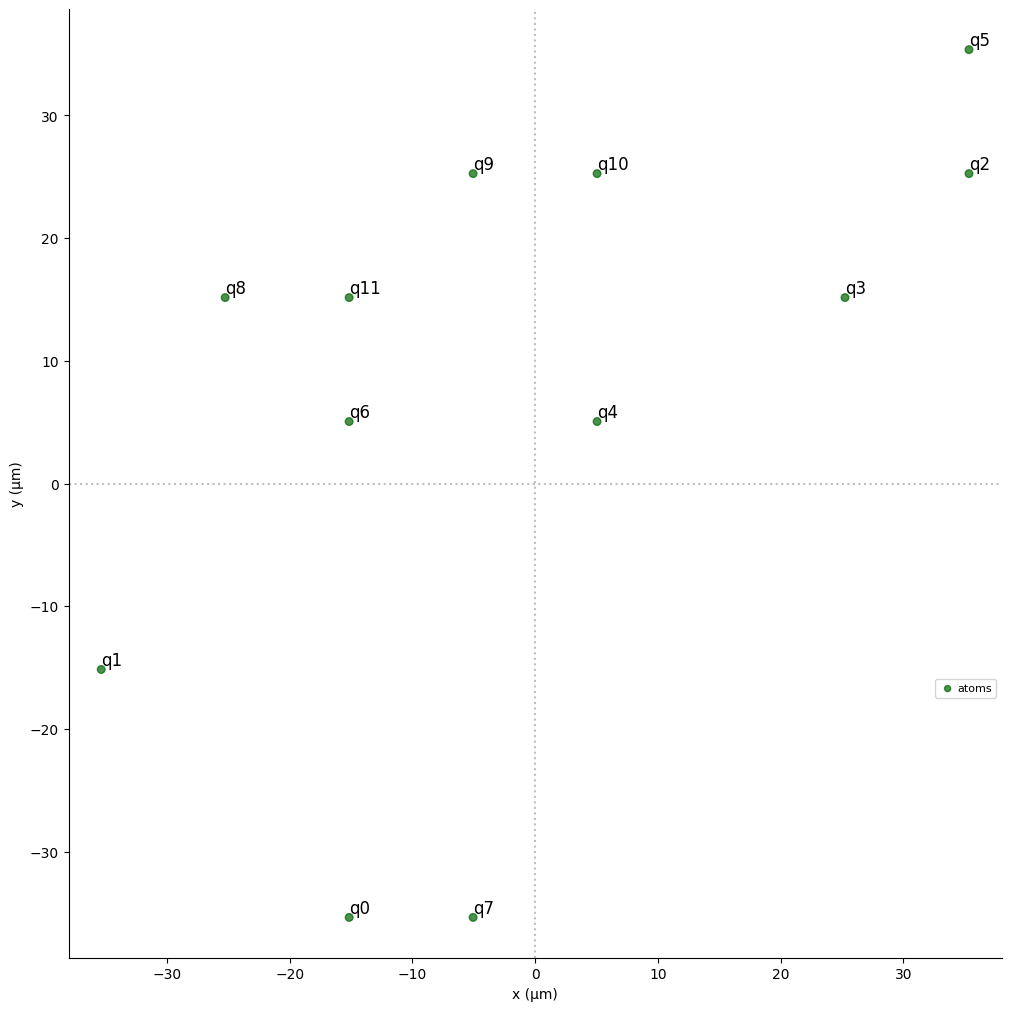

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=7



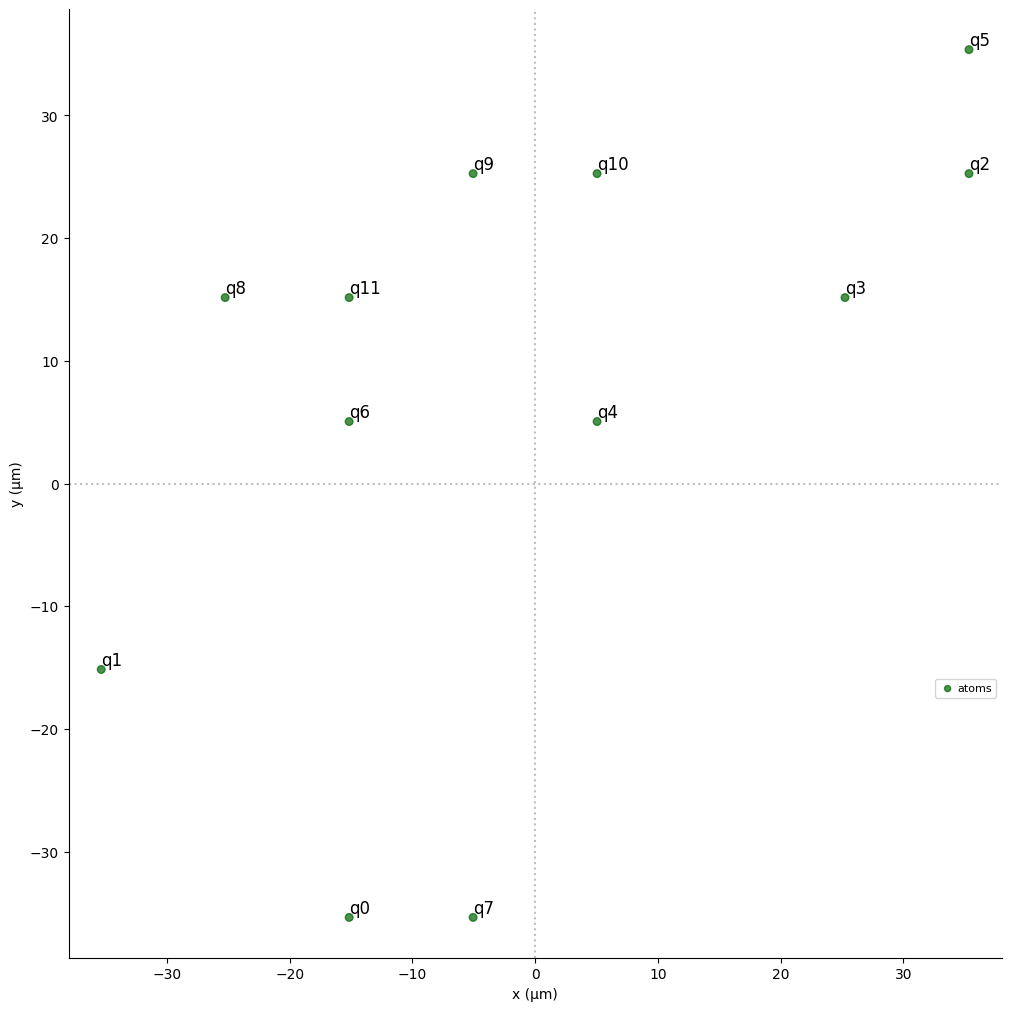

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=8



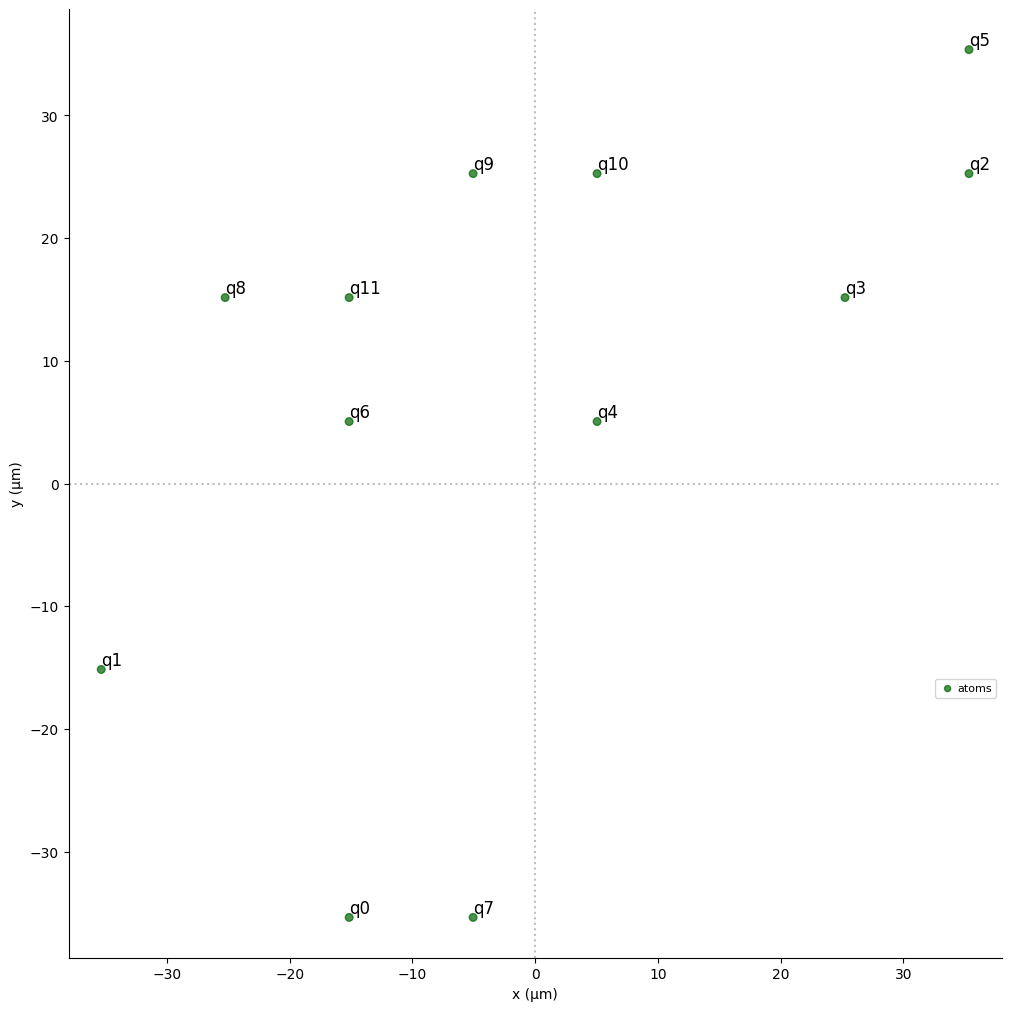

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=9



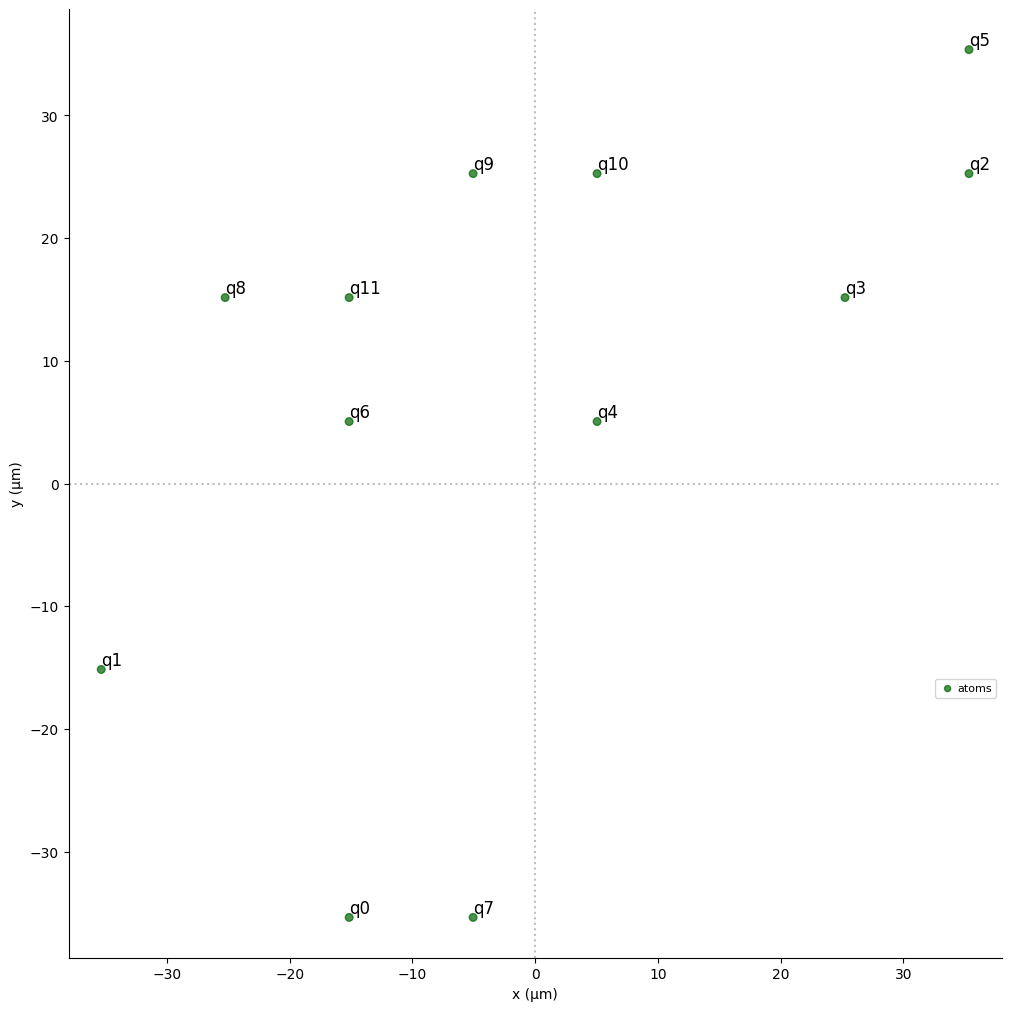

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=10



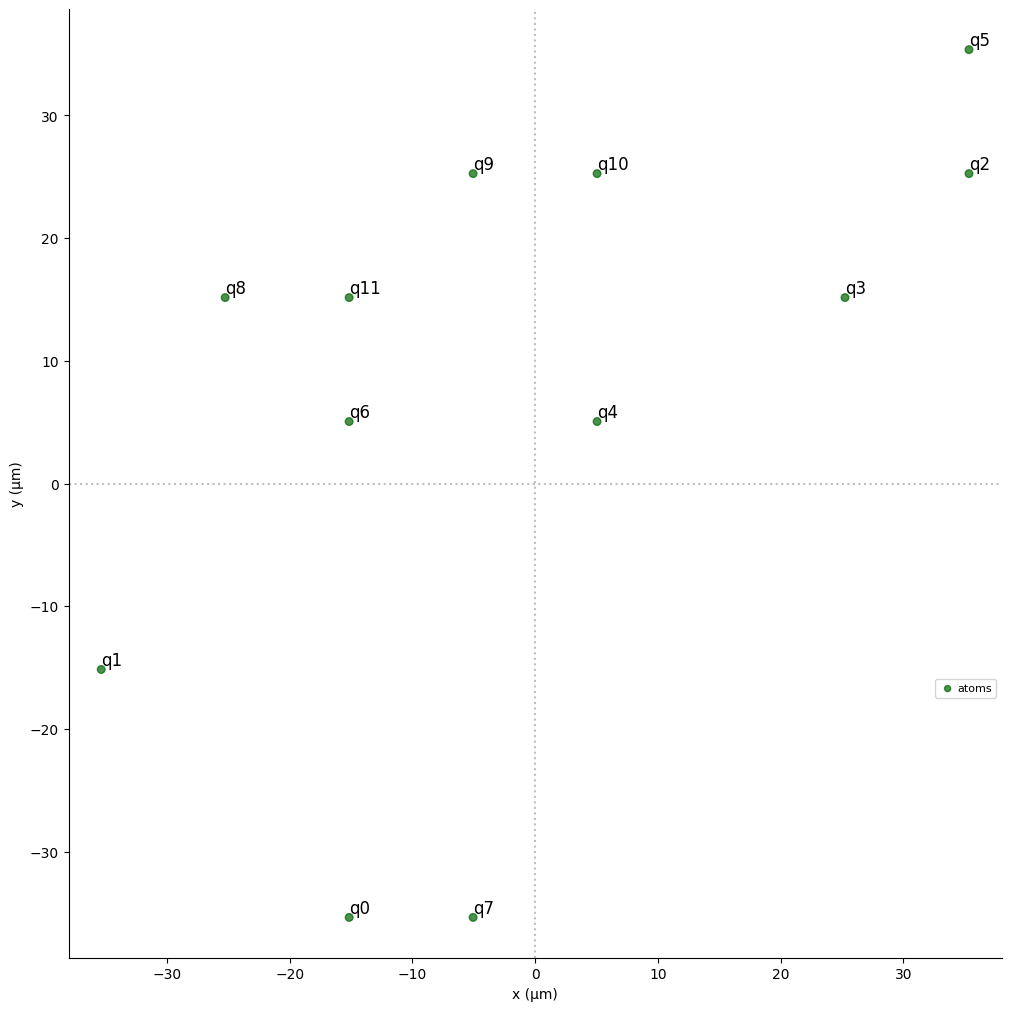

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=3 radius=11



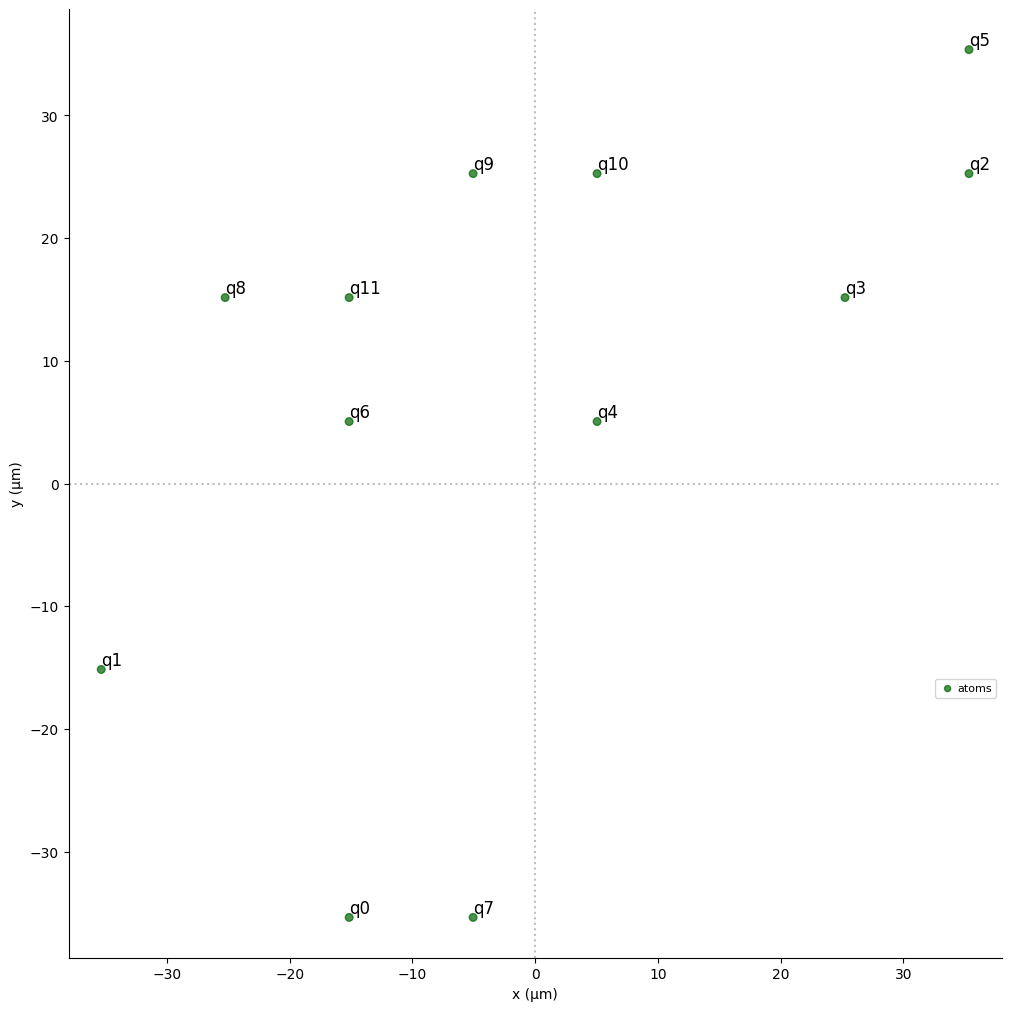

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=3



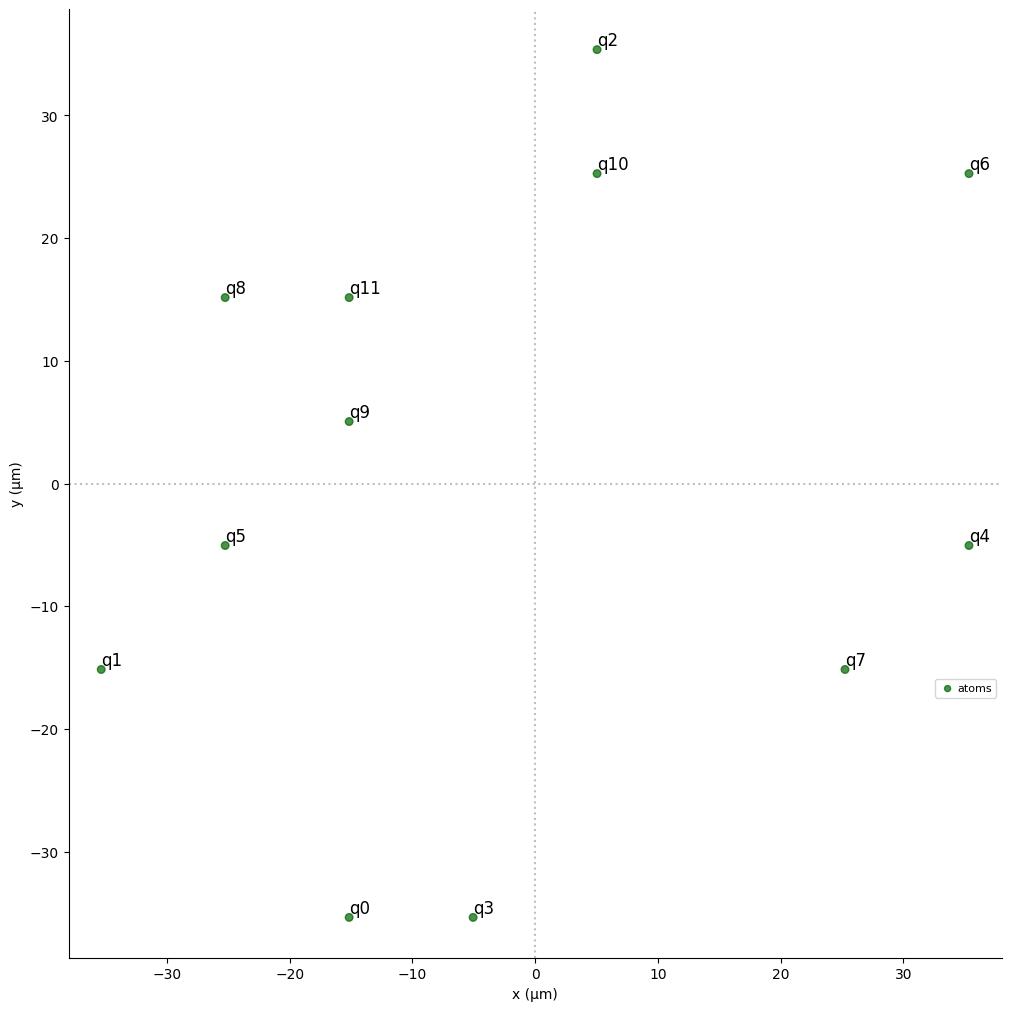

QAA lowest cost 4859.451290504174, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 180.01869795691033
clustering=4 radius=4



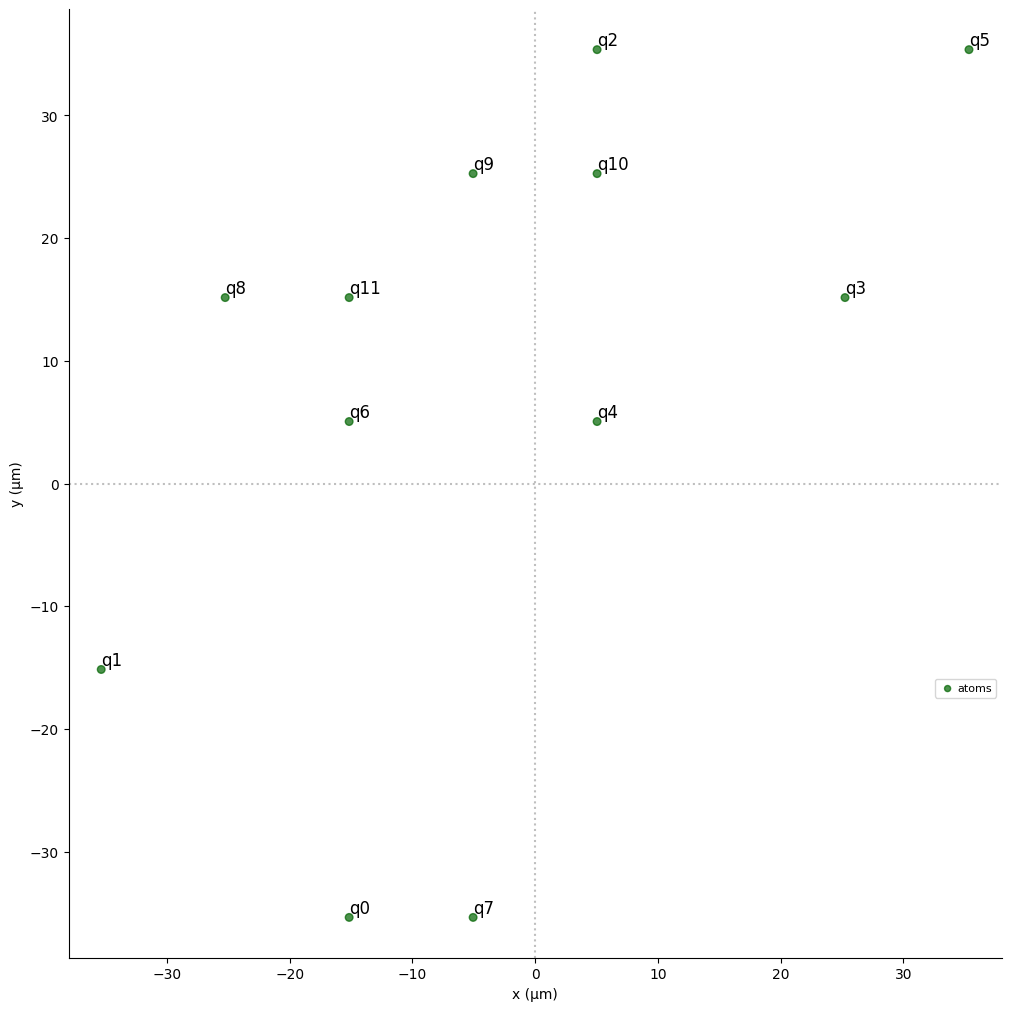

QAA lowest cost 5788.450129032971, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 214.24234843405145
clustering=4 radius=5



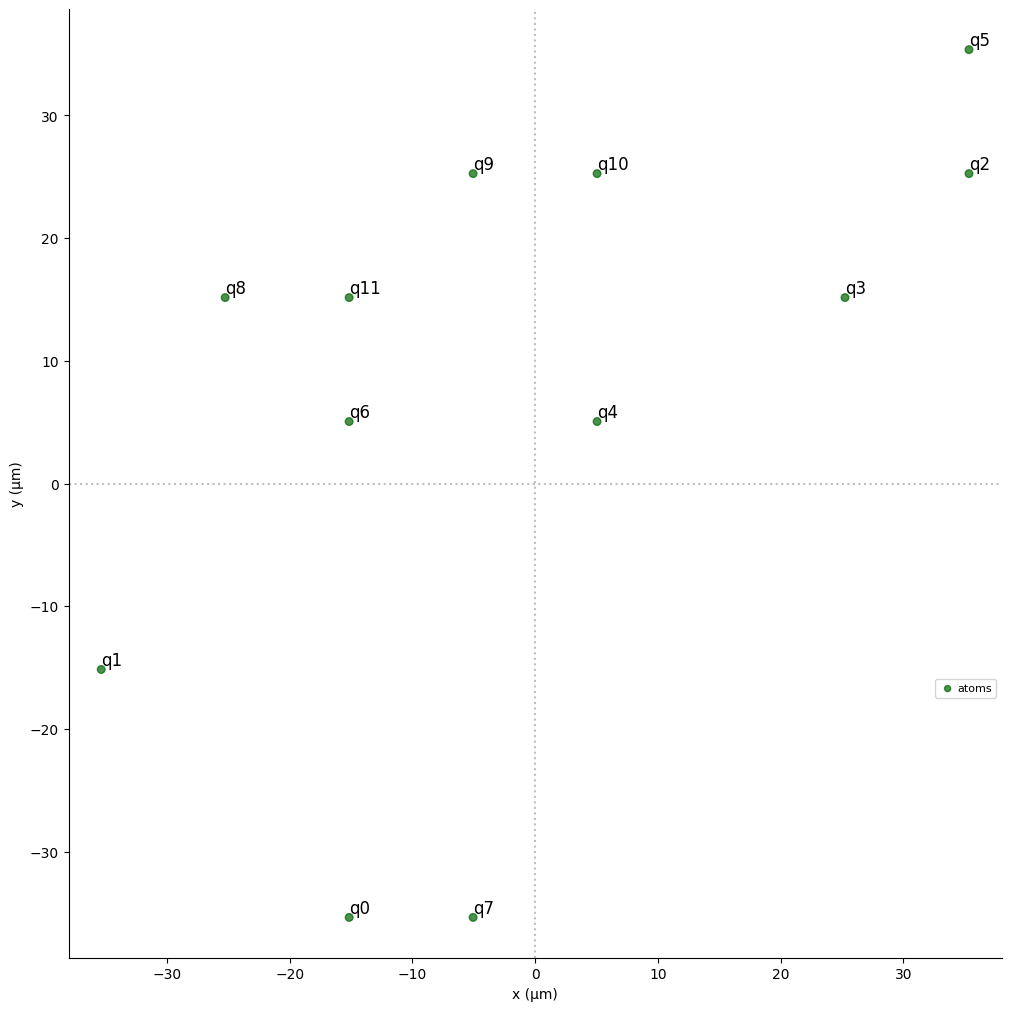

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=6



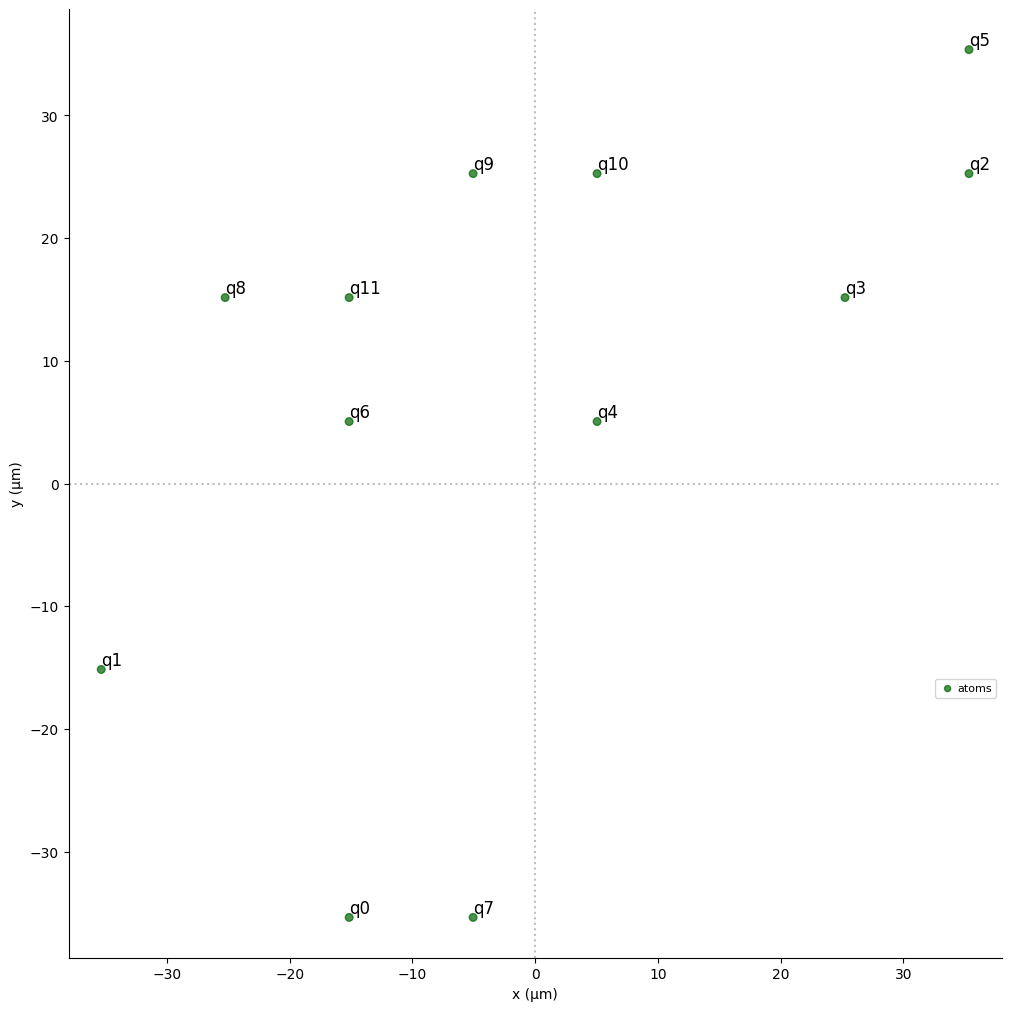

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=7



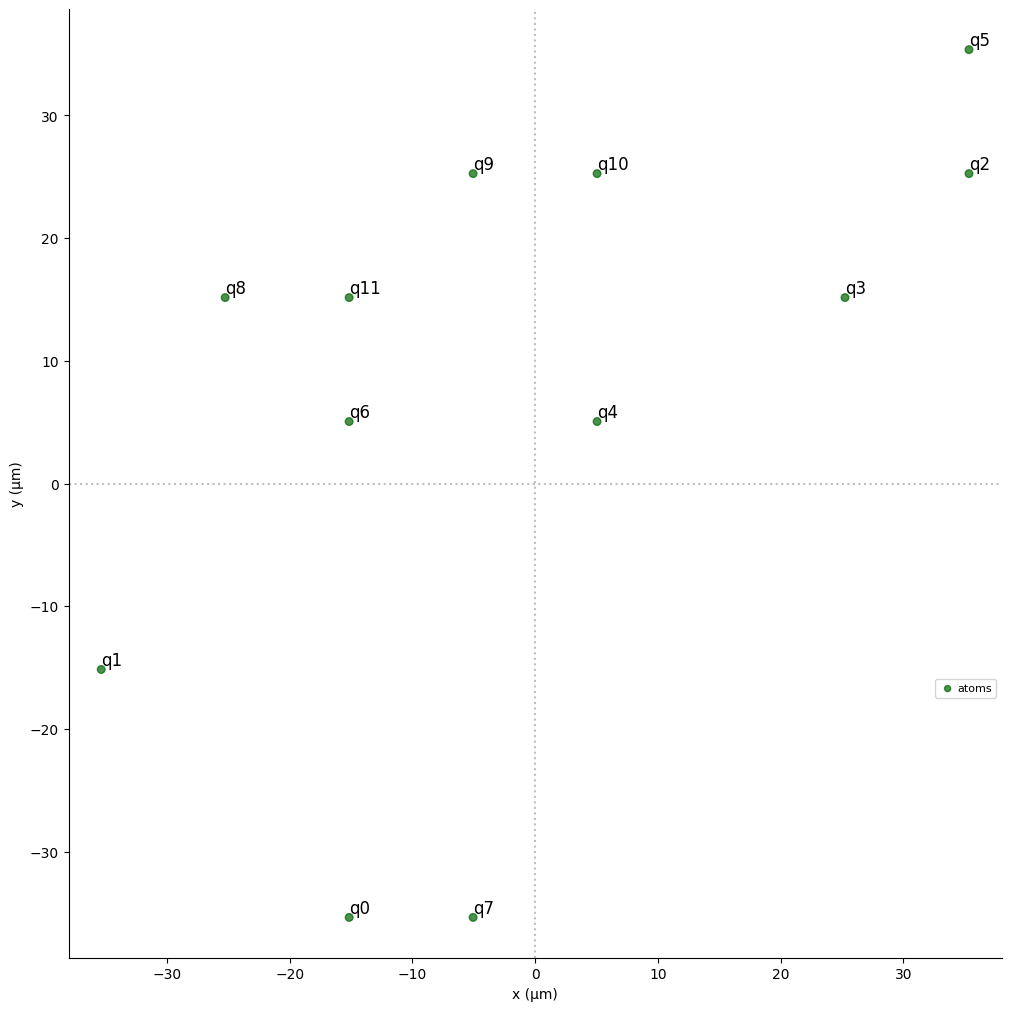

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=8



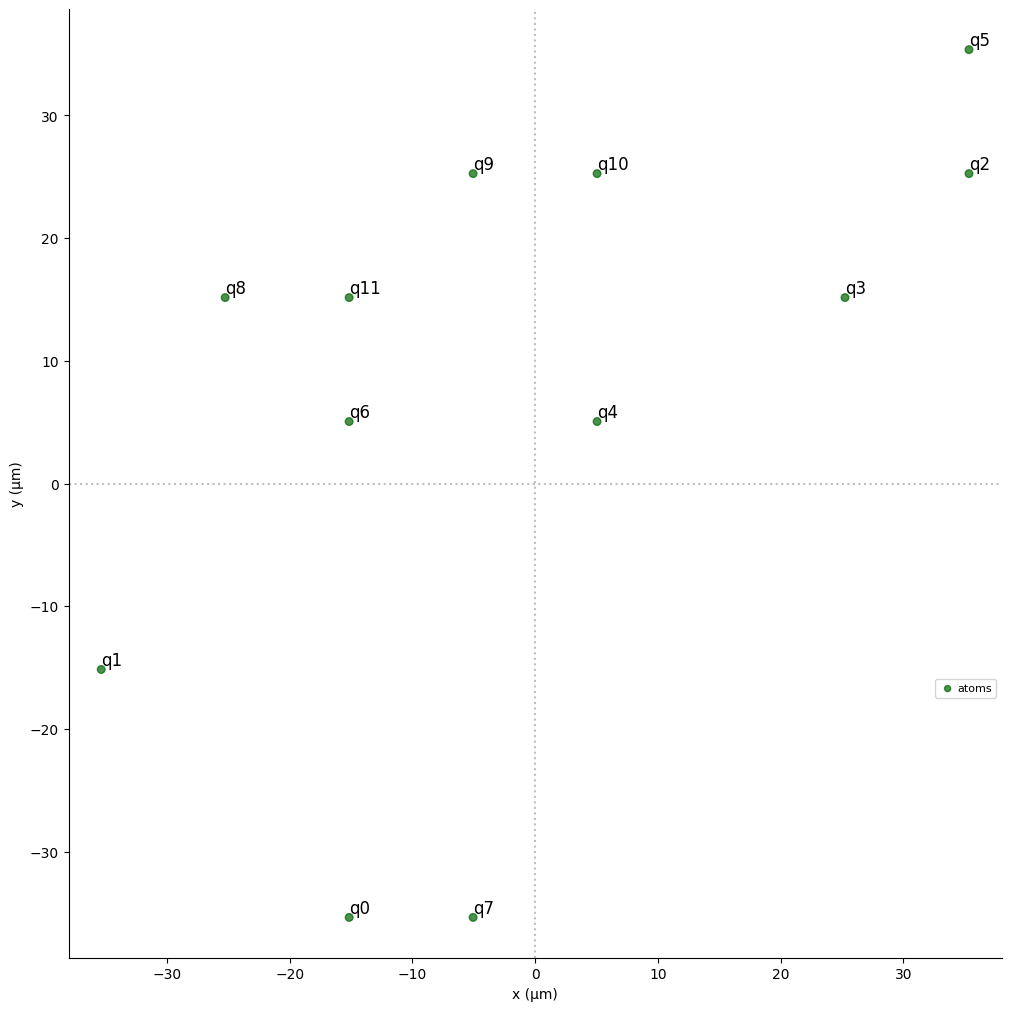

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=9



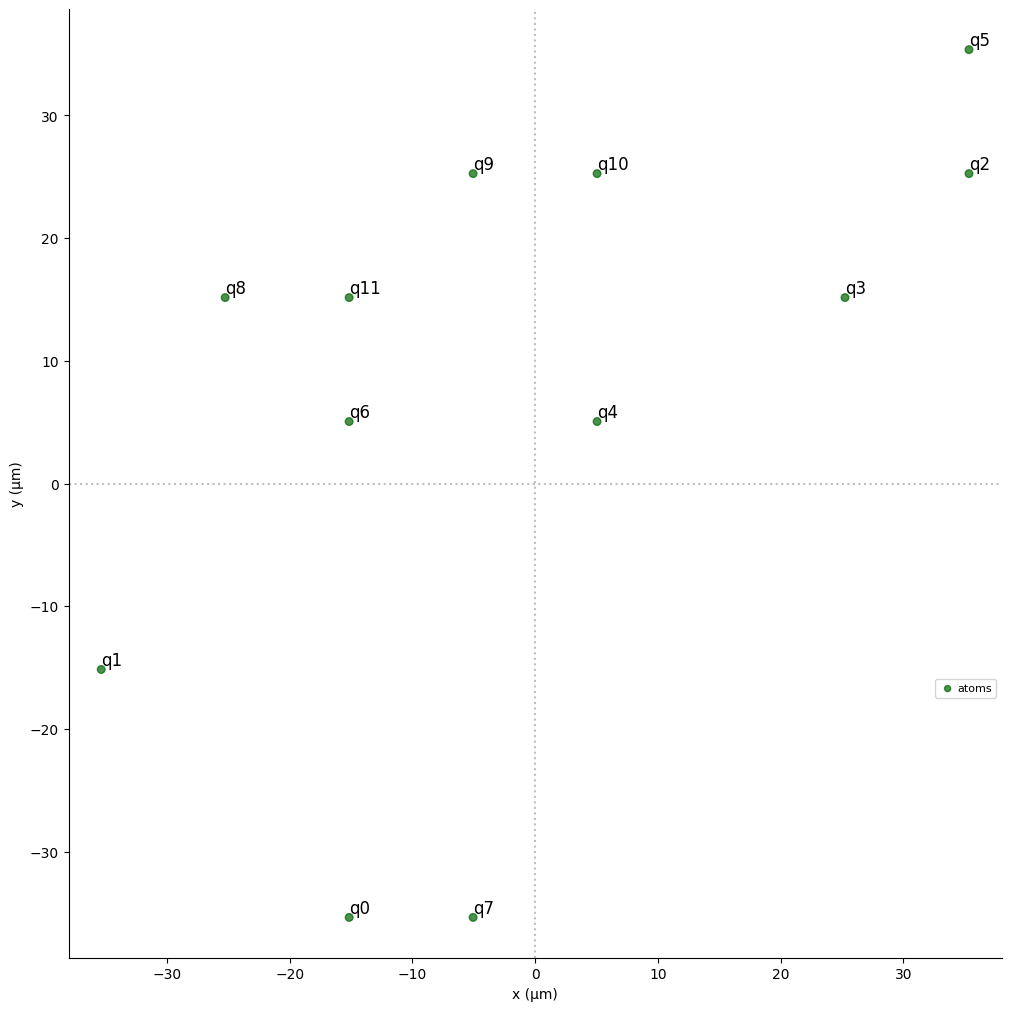

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=10



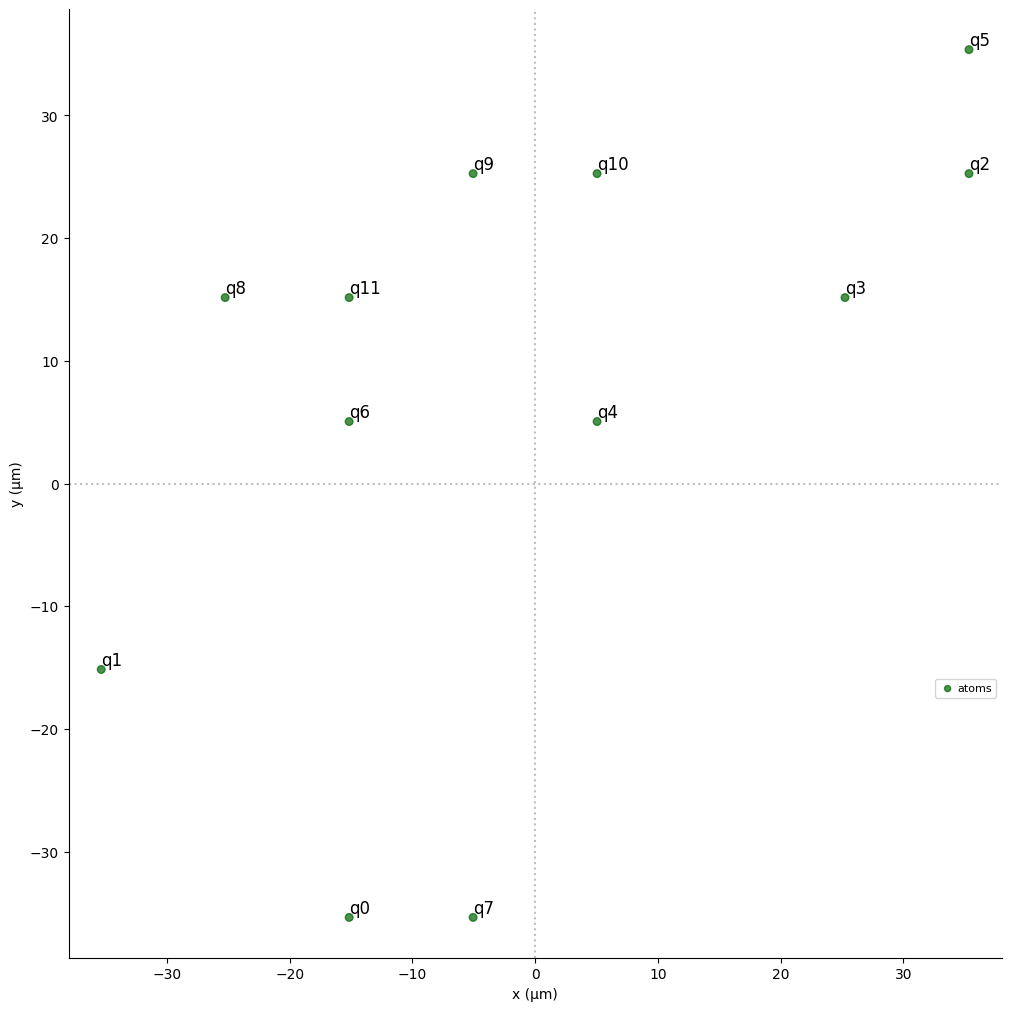

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=4 radius=11



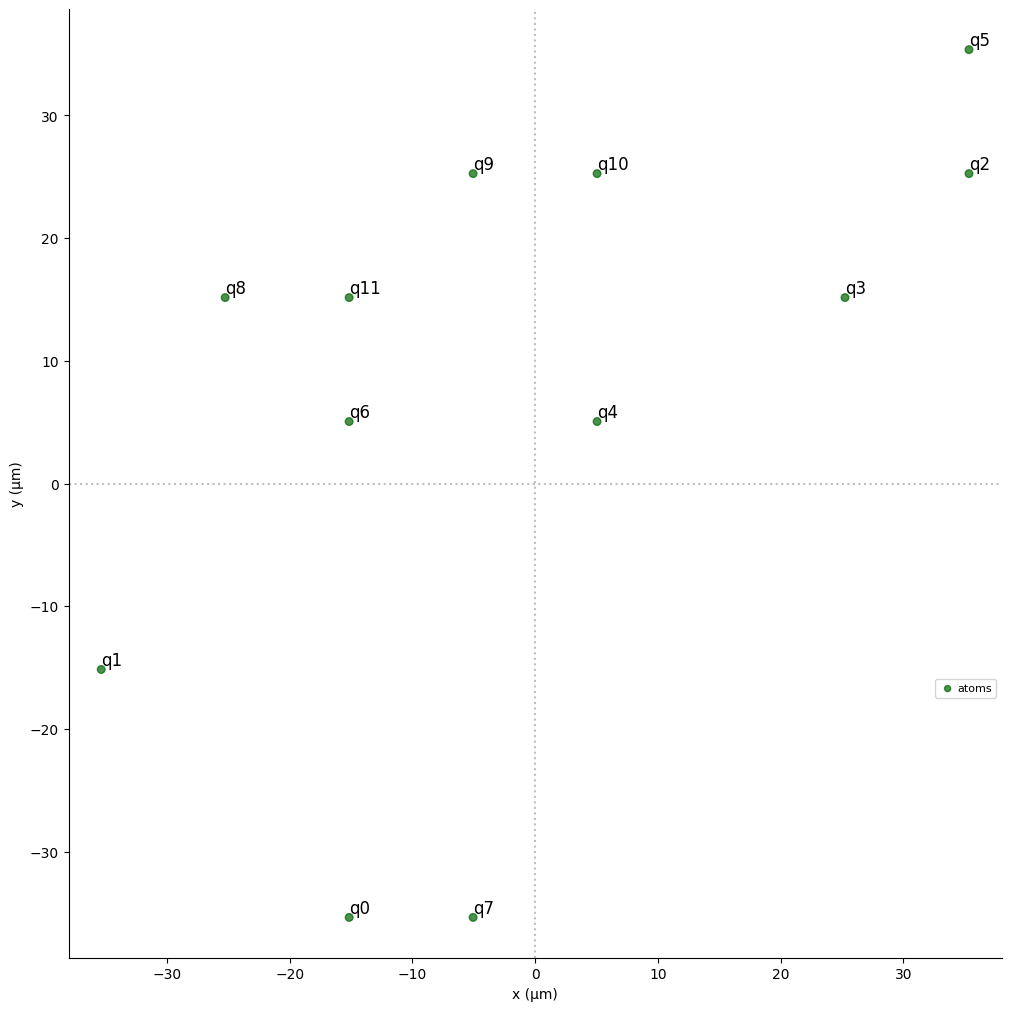

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=3



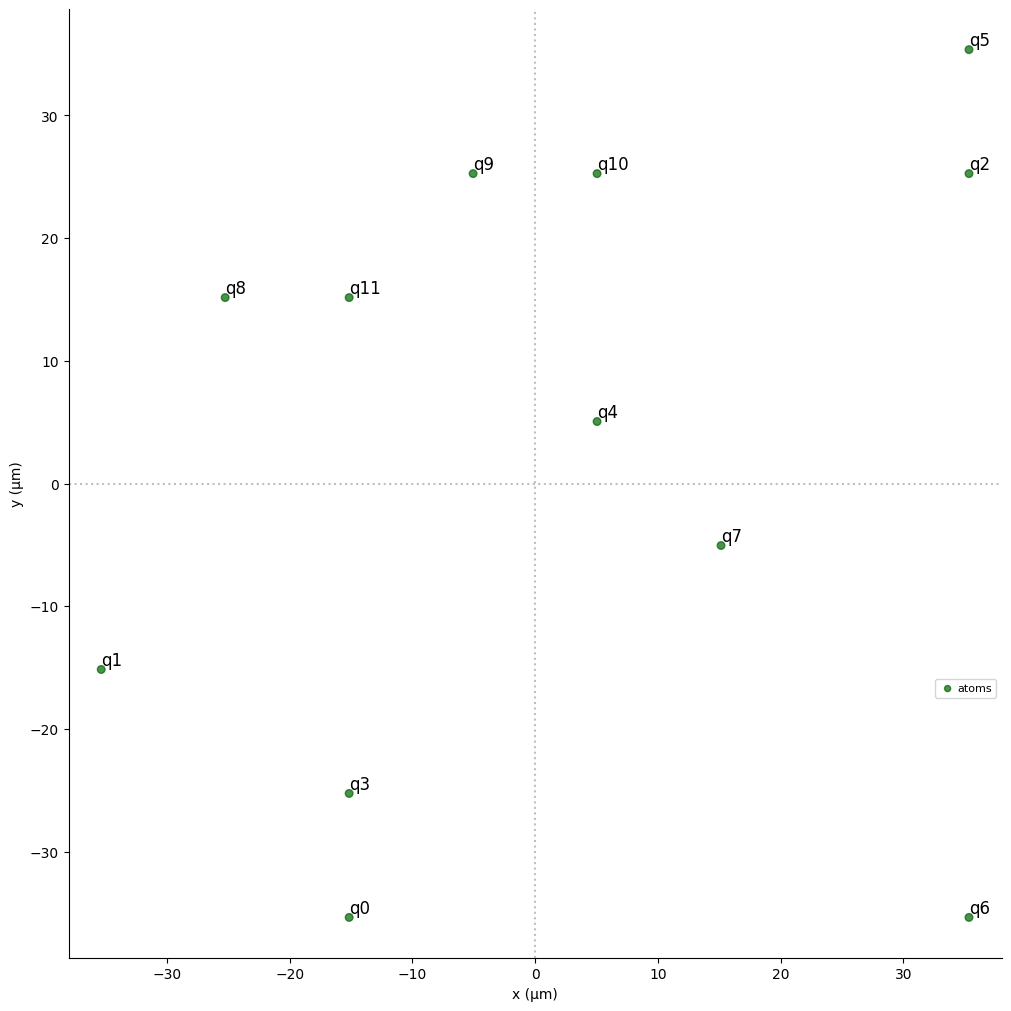

QAA lowest cost 3969.0052807431257, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 147.21530602254845
clustering=5 radius=4



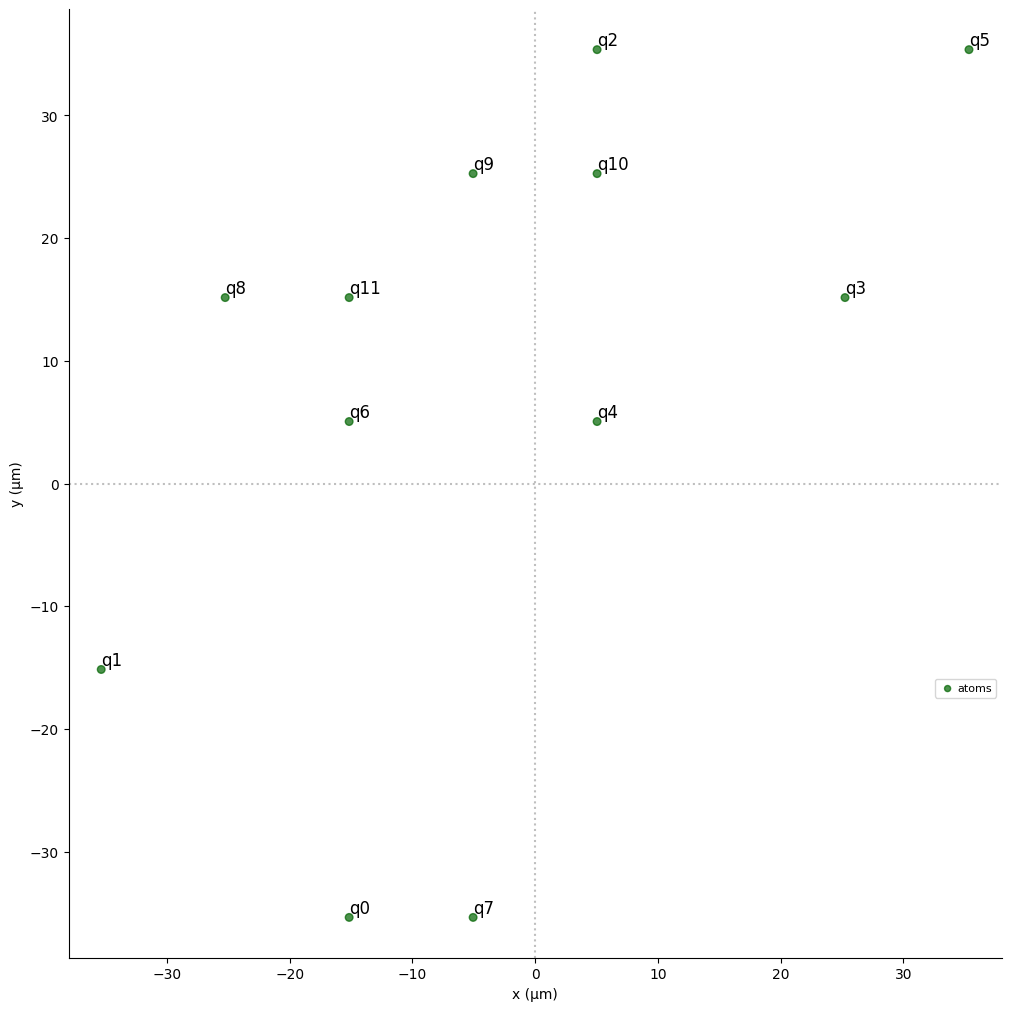

QAA lowest cost 5788.450129032971, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 214.24234843405145
clustering=5 radius=5



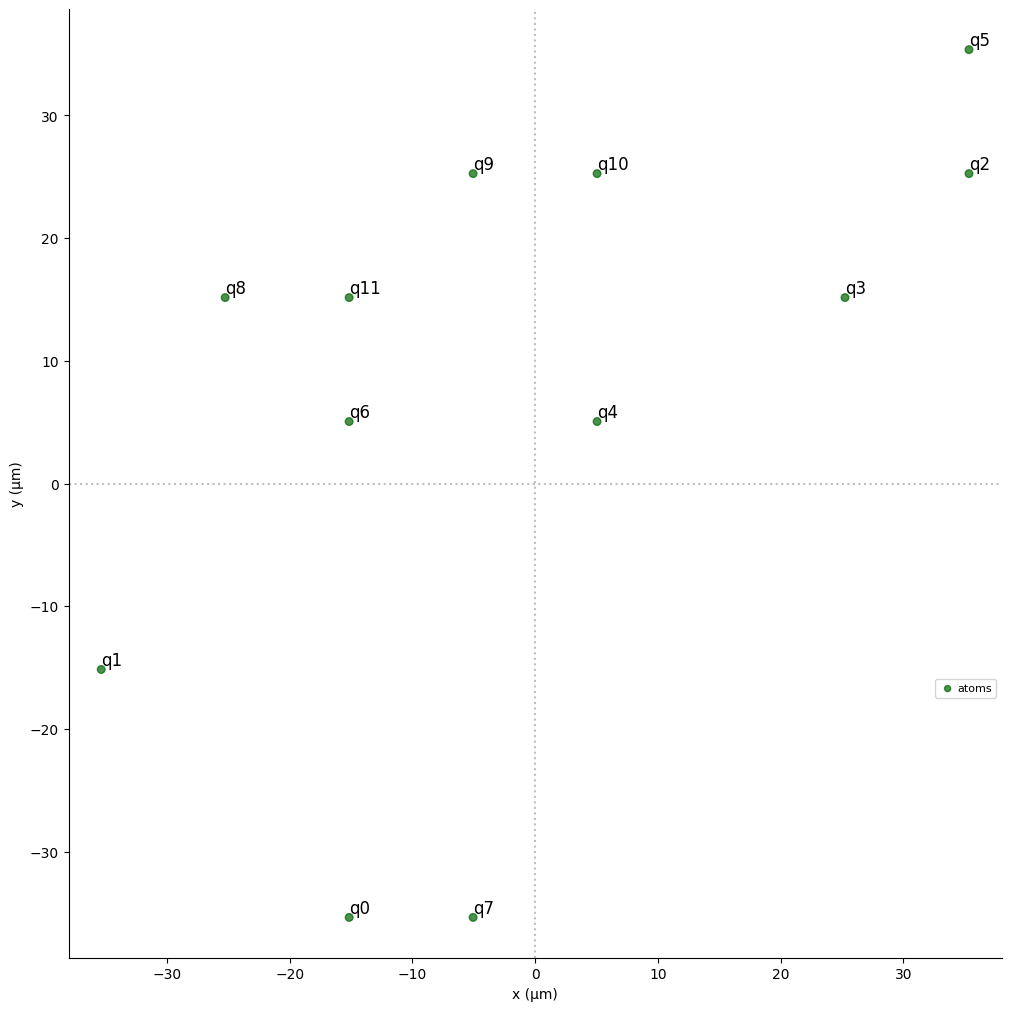

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=6



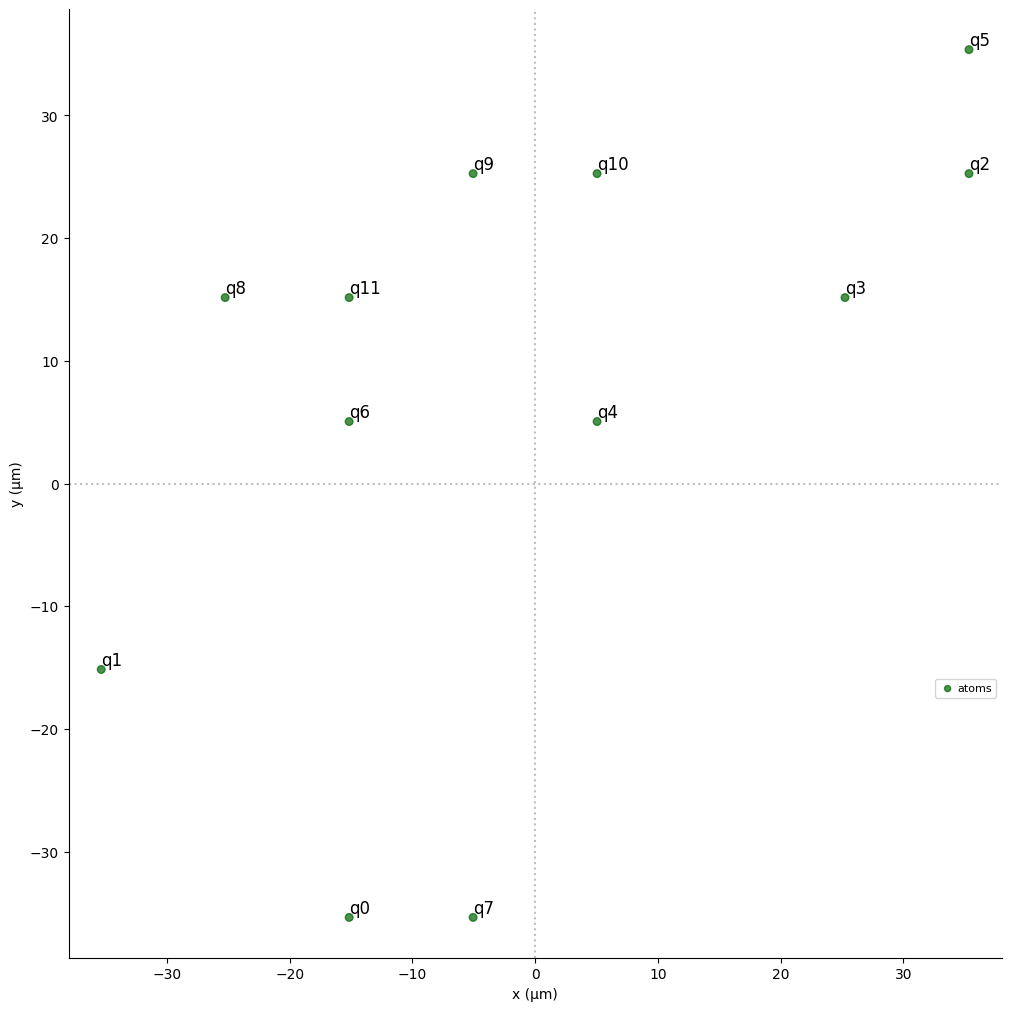

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=7



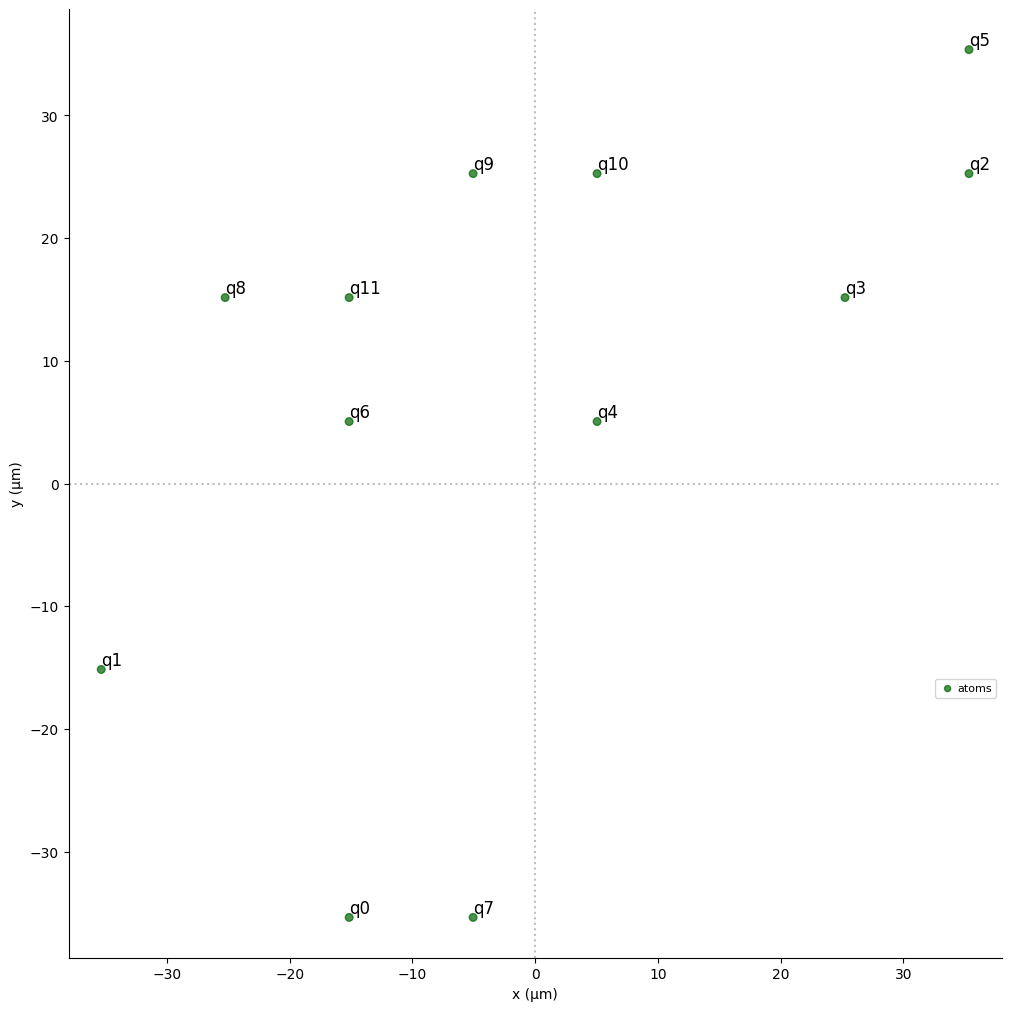

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=8



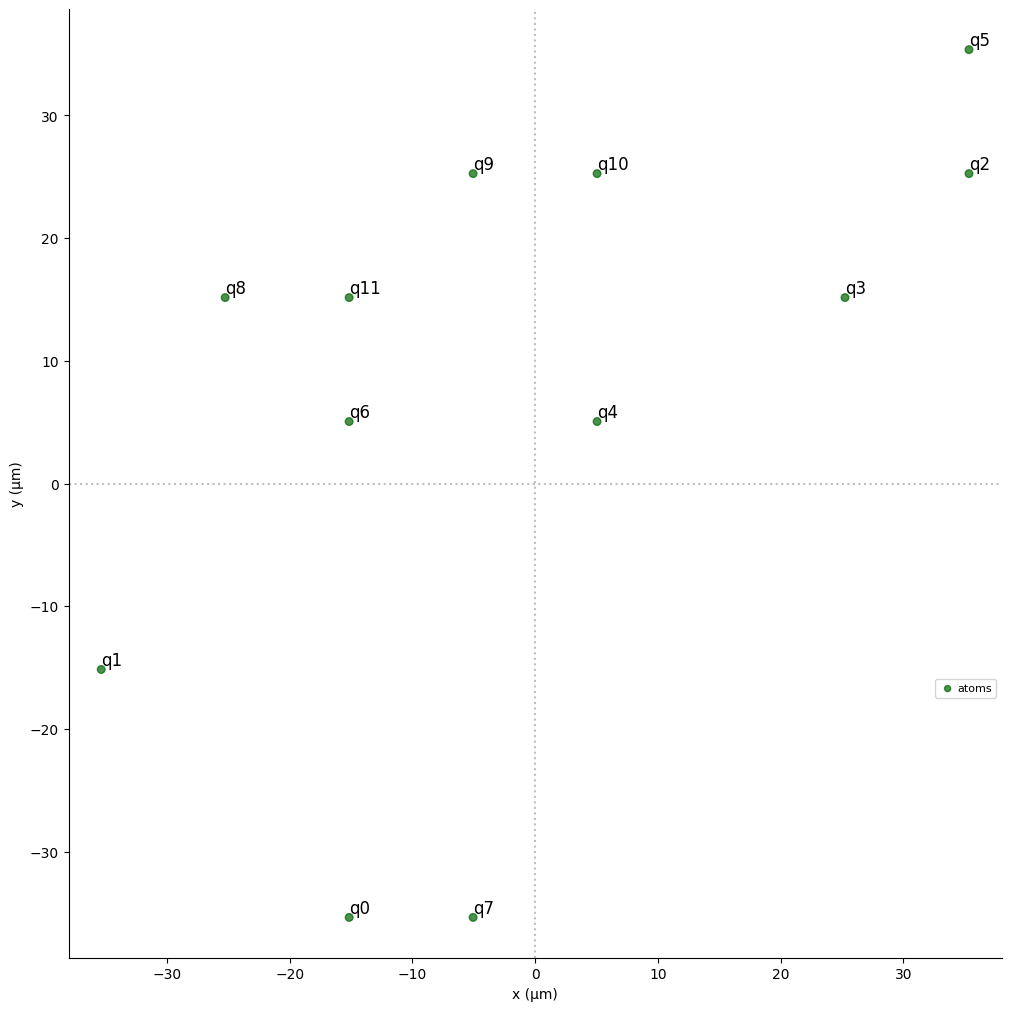

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=9



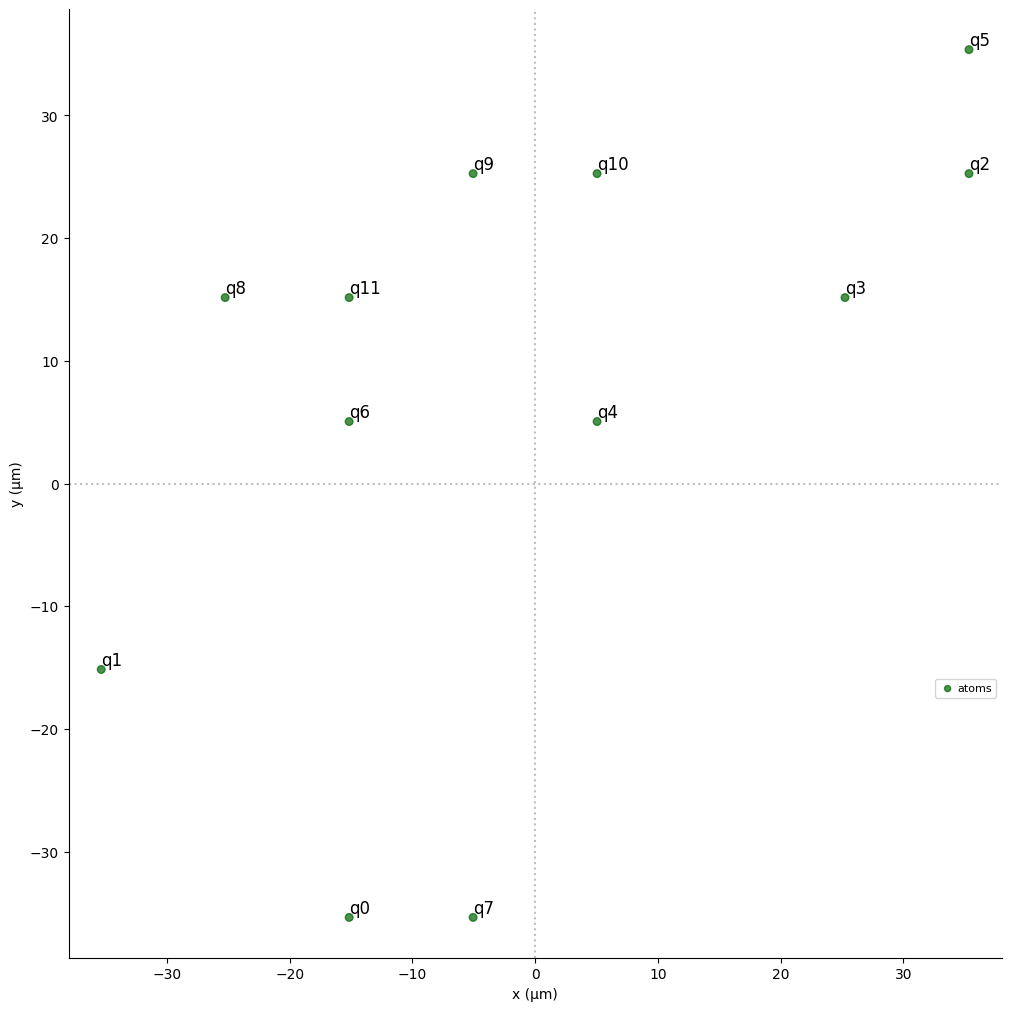

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=10



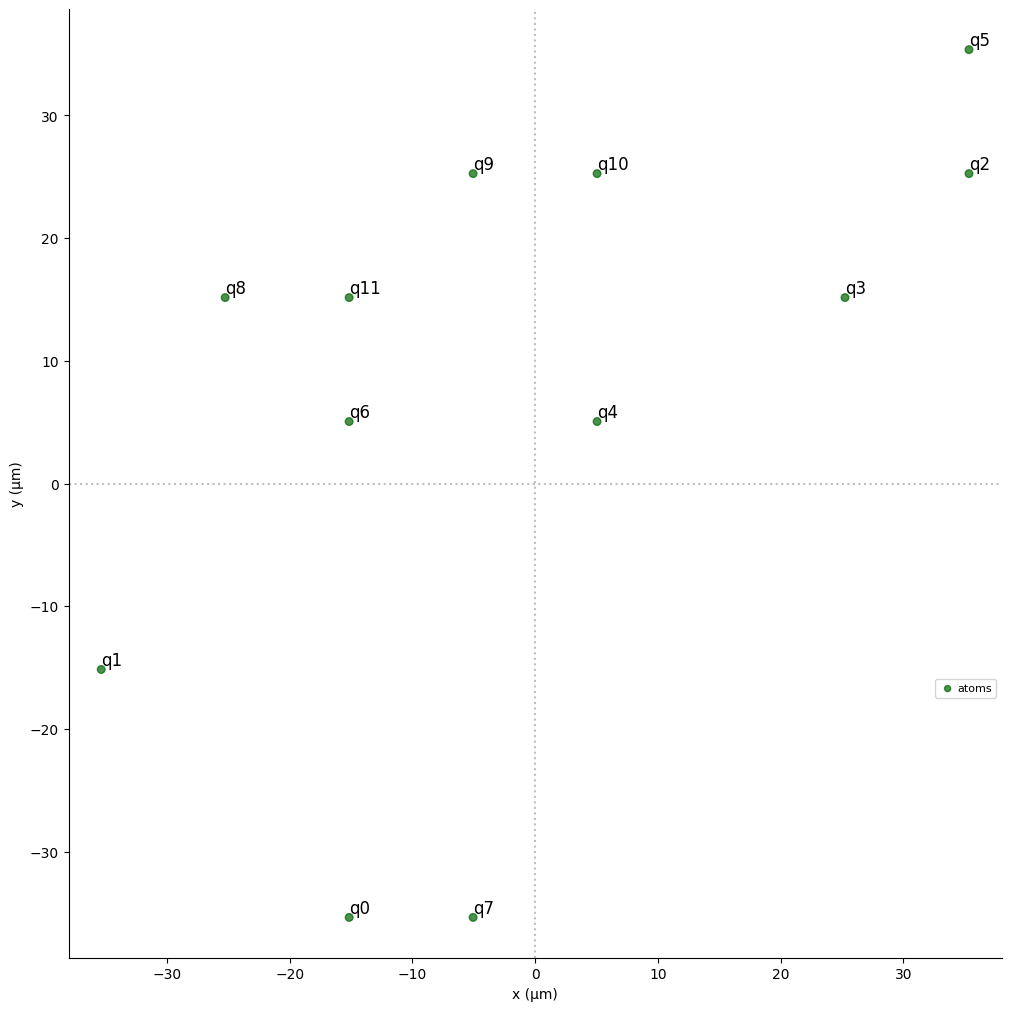

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648
clustering=5 radius=11



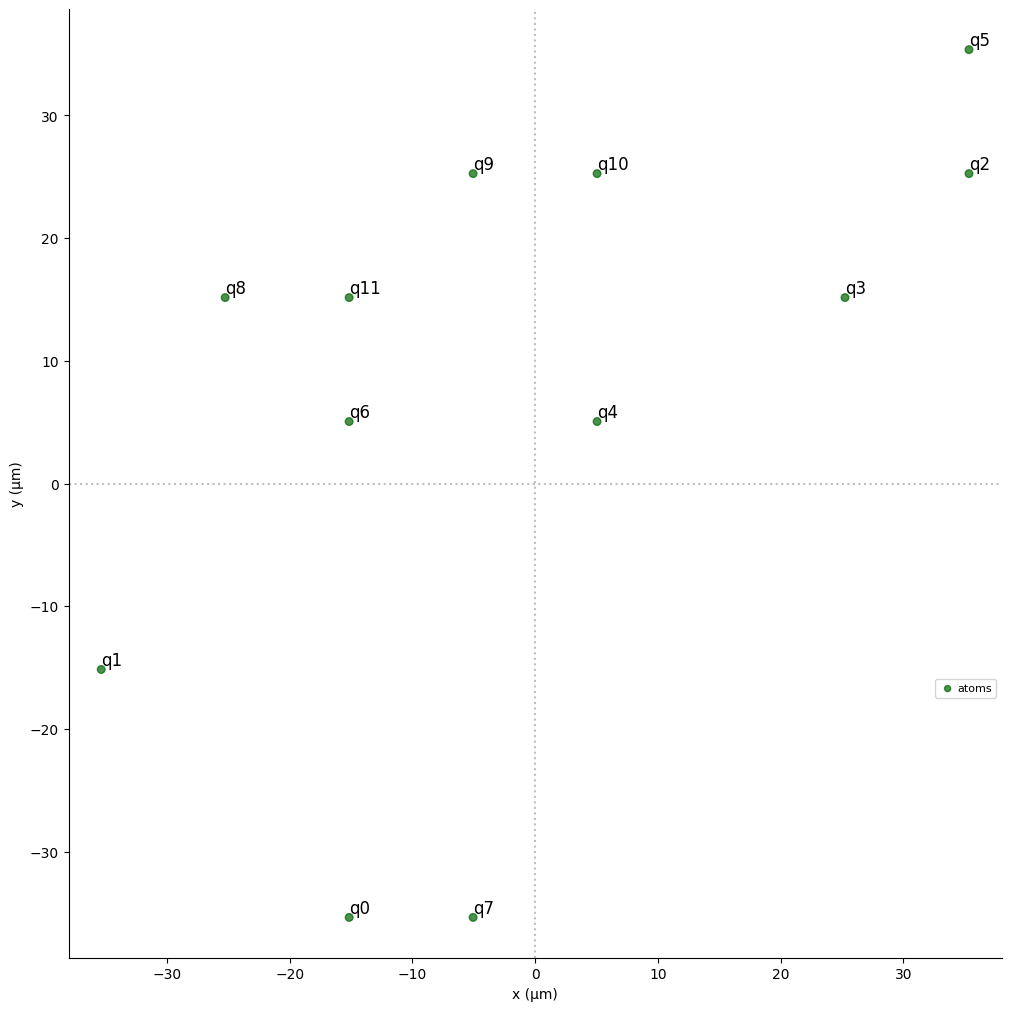

QAA lowest cost 4688.490684285643, lowest cost (found classically) : -27.14493707061728
Ratio QAA/classic : 173.72063192073648


In [80]:
ratios = []
for i in range(1,6):
    for j in range(3,12):
        print(f"clustering={i} radius={j}\n")
        positions, cluster_centers, weight = generate_grid_clustered_graph(8, i, j, total_atoms=12, min_distance=5.0, minimal_capacity=0.2)
        qubits = {f"q{i}": coord for (i, coord) in enumerate(positions)}
        reg = Register(qubits)
        reg.draw()
        Q_loop = coordinates_to_Q(coords)
        lowest_cost_classic = find_minimum_cost_classic(Q_loop)
        lowest_cost_QAA = find_minimum_cost_QAA(Q_loop)
        ratio = (lowest_cost_QAA-lowest_cost_classic[1])/np.abs(lowest_cost_classic[1])
        print(f"QAA lowest cost {lowest_cost_QAA}, lowest cost (found classically) : {lowest_cost_classic[1]}\nRatio QAA/classic : {ratio}")
        ratios.append({f"clustering={i} radius={j}":ratio})

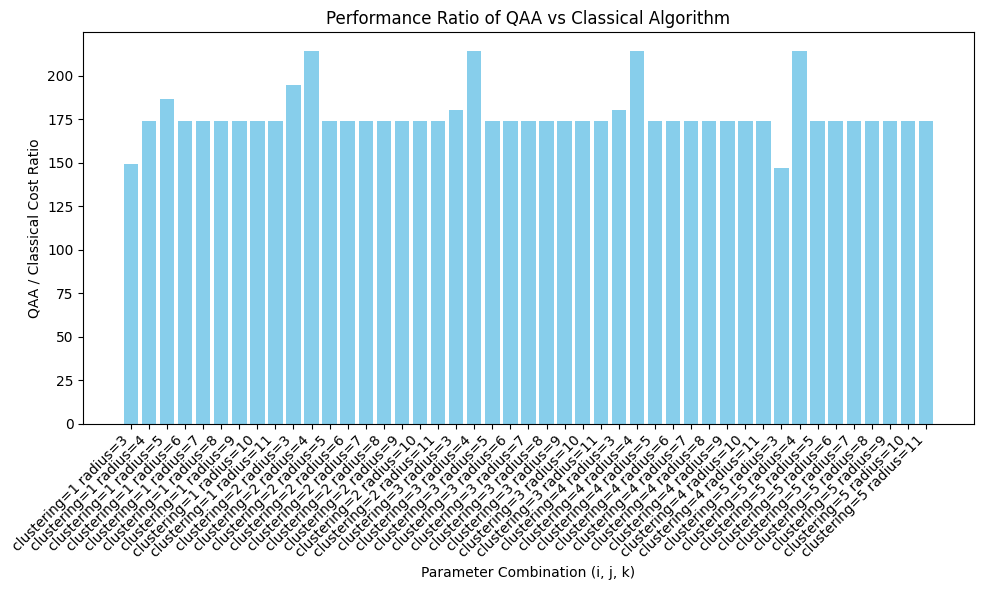

In [81]:
labels = [list(d.keys())[0] for d in ratios]
values = [list(d.values())[0] for d in ratios]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Parameter Combination (i, j, k)")
plt.ylabel("QAA / Classical Cost Ratio")
plt.title("Performance Ratio of QAA vs Classical Algorithm")
plt.tight_layout()
plt.show()